# Simulate  spectra for may 31th 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS FRANCE
- creation date   : 22th October 2017





In [2]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

print theNotebook
from IPython.display import Image, display
import sys
sys.path.append("../../common_tools/")
from common_notebook import *

init_notebook()

SimulateSpectra
ccdproc version 1.2.0
bottleneck version 1.2.1
/Users/dagoret/MacOSX/GitHub/LSST/CTIOAnaJun2017/CTIOAnaJun2017/ana_31may17/HD111980_2


In [4]:
%config InlineBackend.rc = {}
matplotlib.rc_file("../../templates/matplotlibrc")

/Users/dagoret/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'figure.figsize' : (10, 5)})

In [6]:
 from scipy import interpolate

### Import libradtan tools for simulation

In [7]:
path_libradtrantools=os.getenv('CTIOAnaJun2017DIR')+'/spectrumsim/libradtransim'

In [8]:
import sys
sys.path.append(path_libradtrantools)

In [9]:
from libsimulateTranspCTIOScattAbs import *

In [10]:
path_libctiosim=os.getenv('CTIOAnaJun2017DIR')+'/spectrumsim'

In [11]:
sys.path.append(path_libctiosim)
import libCTIOTransm as ctiosim 

### import pysynphot tools for CALSPEC SED

In [12]:
os.environ['PYSYN_CDBS']

'/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs'

In [13]:
import pysynphot as S
from astropy.io import ascii

### CTIO detector sim data

In [14]:
os.getenv('CTIOAnaJun2017DIR')

'/Users/dagoret/MacOSX/GitHub/LSST/CTIOAnaJun2017/CTIOAnaJun2017'

In [15]:
path_ctiodata=os.getenv('CTIOAnaJun2017DIR')+'/spectrumsim/CTIOThroughput'
qe_filename='qecurve.txt'

### My Humidity tools

My own tools to convert relative humidty into precipitable water vapor.
The question is that we start from humidity at ground and we extrapolate the PWV for the whole column depth.
This may be bad. That is why we measure PWV.

In [16]:
path_humidity=os.getenv('CTIOAnaJun2017DIR')+'/humidity'
sys.path.append(path_humidity)
import humidity as hum
import libhumidity_ctio as humctio

# Initialisation

## Input fits file

- containing the calibrated spectra

In [17]:
inputdir="./spectrum_calibspec"
MIN_IMGNUMBER=74
MAX_IMGNUMBER=108
date="20170531"
object_name='HD111980'
tag = "calibSpectra"
SelectTagRe='^%s_%s_([0-9]+).fits$' % (tag,date) # regular expression to select the file
SearchTagRe='^%s_%s_[0-9]+.fits$' % (tag,date)
NBIMGPERROW=2

## Initialisation for CTIO transmission

### Get Quantum Efficiency

In [18]:
wl_qe,tr_qe=ctiosim.Get_QE()

In [19]:
# Quantum efficiency through PySynPhot
bp_ctio_qe = S.ArrayBandpass(wl_qe*10.,tr_qe, name='CTIO QE')

### Get mirror efficiency

In [20]:
wl_m,tr_m=ctiosim.Get_Mirror()

In [21]:
# Quantum efficiency through PySynPhot
bp_ctio_m = S.ArrayBandpass(wl_m*10.,tr_m*tr_m, name='CTIO Mirror2')  # two mirrors

### Get Filter transmission

In [22]:
wl_f_red,tr_f_red=ctiosim.Get_RG175()
wl_f_blue,tr_f_blue=ctiosim.Get_FGB37()

In [23]:
bp_ctio_f_red = S.ArrayBandpass(wl_f_red*10.,tr_f_red, name='RG175')  # two mirrors
bp_ctio_f_blue = S.ArrayBandpass(wl_f_blue*10.,tr_f_blue, name='FGB37')  # two mirrors

### Combine or not with filters

In [24]:
# With Filters:
#----------------
bp_ctio_red=bp_ctio_qe*bp_ctio_m*bp_ctio_f_red
bp_ctio_blue=bp_ctio_qe*bp_ctio_m*bp_ctio_f_blue
#Without filters
#----------------
bp_ctio_nof=bp_ctio_qe*bp_ctio_m

## Get SED from CALSPEC 

In [25]:
CTIO_COLL_SURF=0.9*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [26]:
S.refs.setref(area=CTIO_COLL_SURF.decompose(), waveset=None)
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, delta=10, log=False)

### Be carefull, names may be wrong in headers

In [27]:
calspec_sed={'HD111980':'hd111980_stis_003.fits',\
             'HD205905':'hd205905_stis_003.fits',\
             'HD185975':'hd185975_stis_003.fits',\
             'HD11980':'hd111980_stis_003.fits','test':'hd111980_stis_003.fits'}       

In [28]:
#filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec',calspec_sed)
#sed = S.FileSpectrum(filename)

## Output directory

In [29]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images
ensure_dir(dir_top_images) # create that directory

outputdir="./simandcalibspec"
ensure_dir(outputdir)

# Open input file

In [30]:
sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe)

In [31]:
all_headers, \
all_dates, \
all_objects, \
all_airmass, \
all_titles, \
all_exposures, \
all_ut, all_ra,all_dec,all_epoch,all_zenith,all_ha,all_st,all_alt,all_focus,\
all_temp, all_press,all_hum,all_windsp,\
all_seeing,all_seeingam,\
all_filt,all_filt1,all_filt2,\
all_leftspectra_data, \
all_rightspectra_data, \
all_leftspectra_data_stat_err ,\
all_rightspectra_data_stat_err ,\
all_leftspectra_wl,\
all_rightspectra_wl, \
all_totleftspectra_data, \
all_totrightspectra_data=BuildCalibSpecFull(sorted_files,sorted_numbers)

## Test Pressure

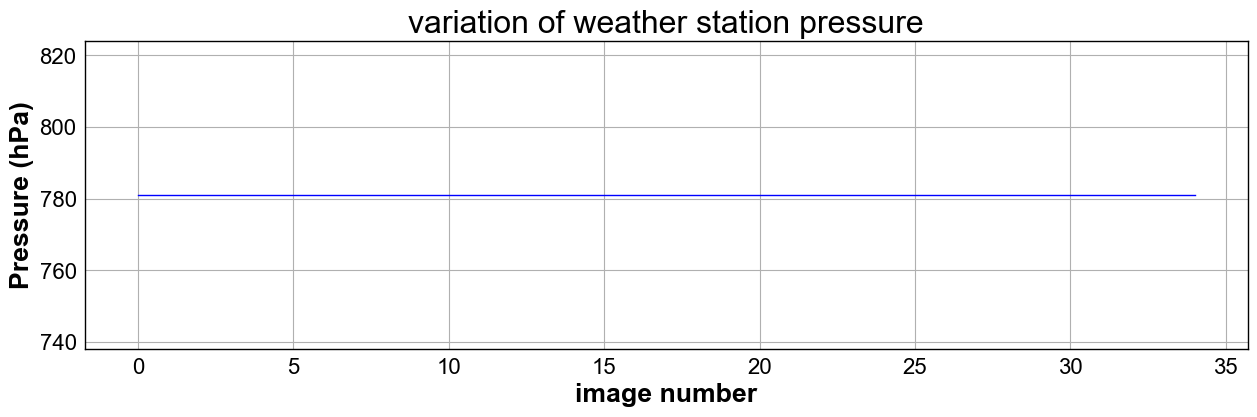

In [32]:
plt.figure(figsize=(15,4))
plt.plot(all_press,'b-')
plt.title("variation of weather station pressure")
plt.xlabel("image number")
plt.ylabel("Pressure (hPa)")

## Test Humidity

In [33]:
all_pwv=[]
idx=0
for press in all_press:
    T=all_temp[idx]+273.
    hum=all_hum[idx]/100.
    pwv=pwv=humctio.HRtoPWV(hum,press,T)
    all_pwv.append(pwv)
    idx+=1

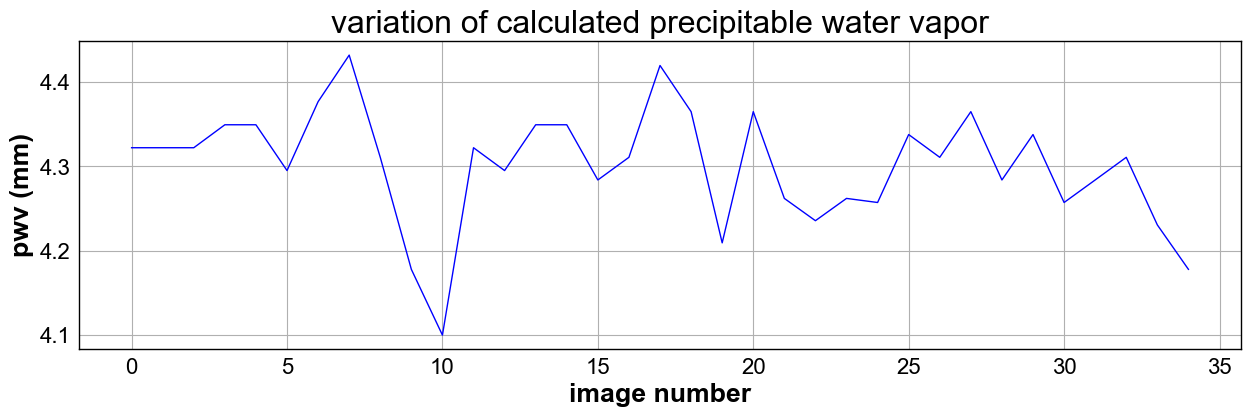

In [34]:
plt.figure(figsize=(15,4))
plt.plot(all_pwv,'b-')
plt.title("variation of calculated precipitable water vapor")
plt.xlabel("image number")
plt.ylabel("pwv (mm)")

# Disperser Sorting

In [35]:
filt0_idx,filt1_idx,filt2_idx,filt3_idx,filt4_idx,filt5_idx,filt6_idx=get_filt_idx(all_filt)

In [36]:
print  Filt_names[0],' \t : filt0_idx :: ',filt0_idx
print  Filt_names[1],' \t : filt1_idx :: ',filt1_idx
print  Filt_names[2],' \t : filt2_idx :: ',filt2_idx
print  Filt_names[3],' \t : filt3_idx :: ',filt3_idx
print  Filt_names[4],' \t : filt4_idx :: ',filt4_idx
print  Filt_names[5],' \t : filt5_idx :: ',filt5_idx
print  Filt_names[6],' \t : filt6_idx :: ',filt6_idx

dia Ron400  	 : filt0_idx ::  [ 0  5 10 15 20 25 30]
dia Thor300  	 : filt1_idx ::  [ 1  6 11 16 21 26 31]
dia HoloPhP  	 : filt2_idx ::  [ 2  7 12 17 22 27 32]
dia HoloPhAg  	 : filt3_idx ::  [ 3  8 13 18 23 28 33]
dia HoloAmAg  	 : filt4_idx ::  [ 4  9 14 19 24 29 34]
dia Ron200  	 : filt5_idx ::  []
Unknown  	 : filt6_idx ::  []


# Show Spectra

/Users/dagoret/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


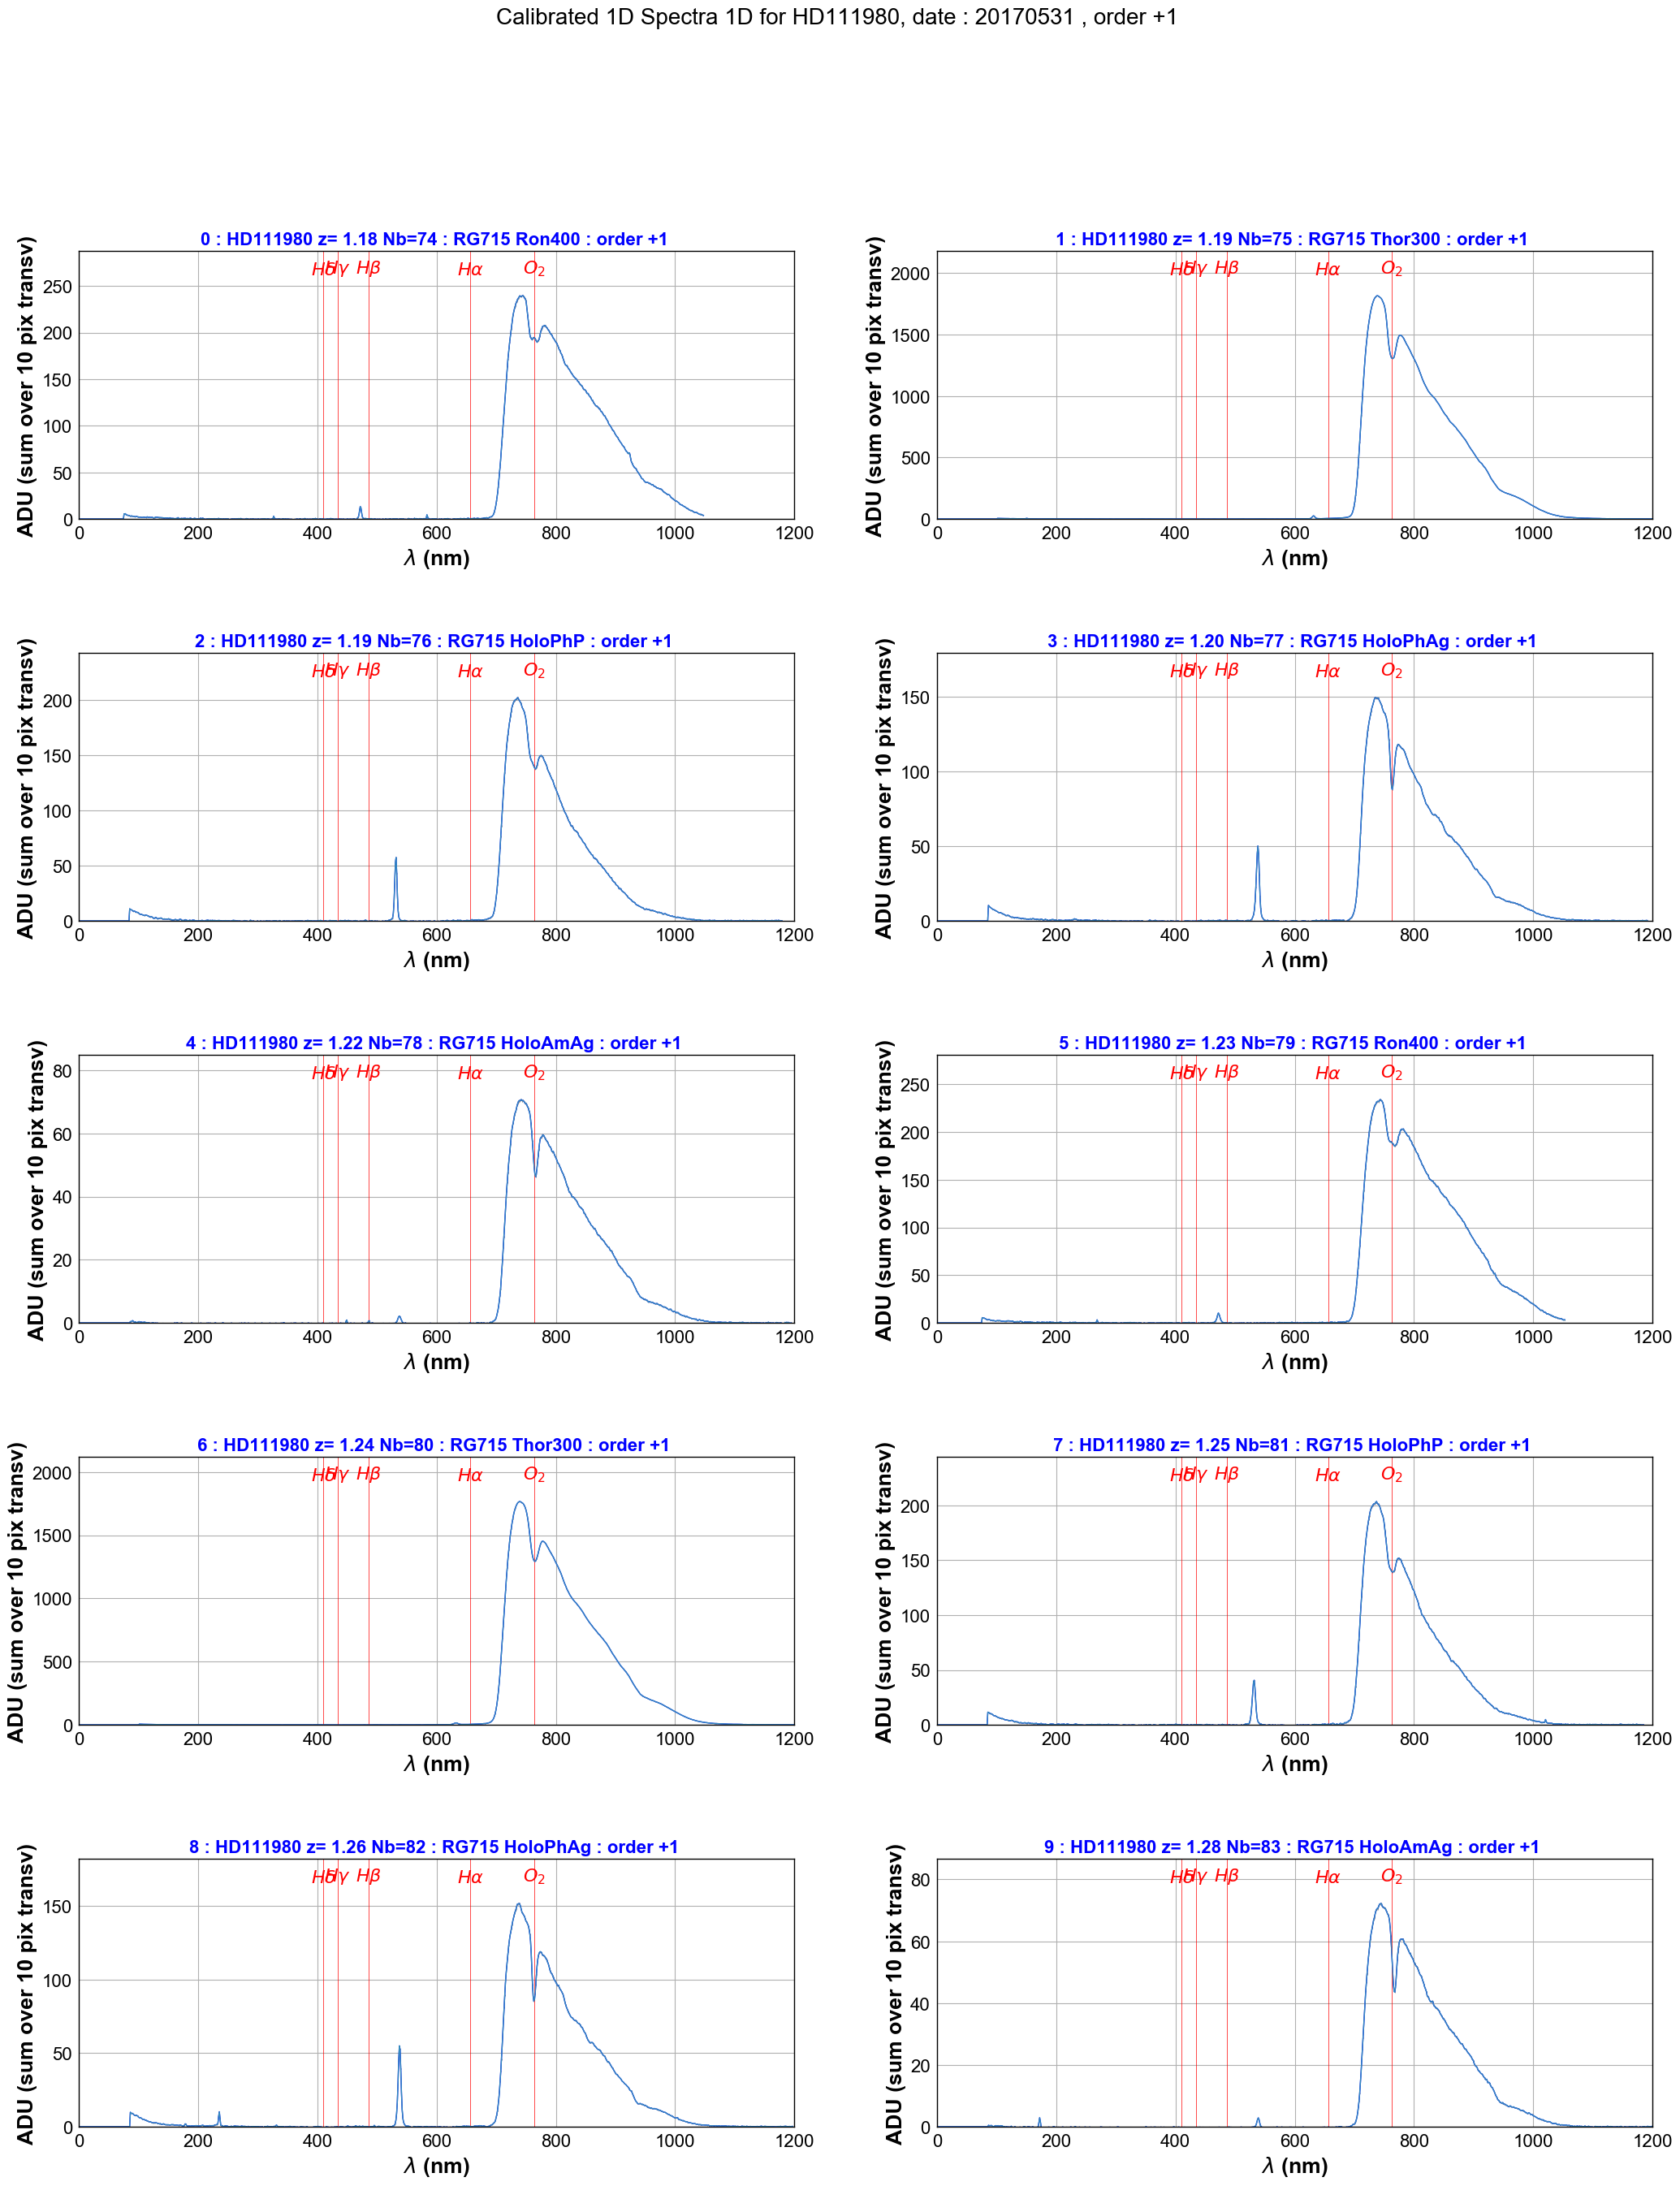

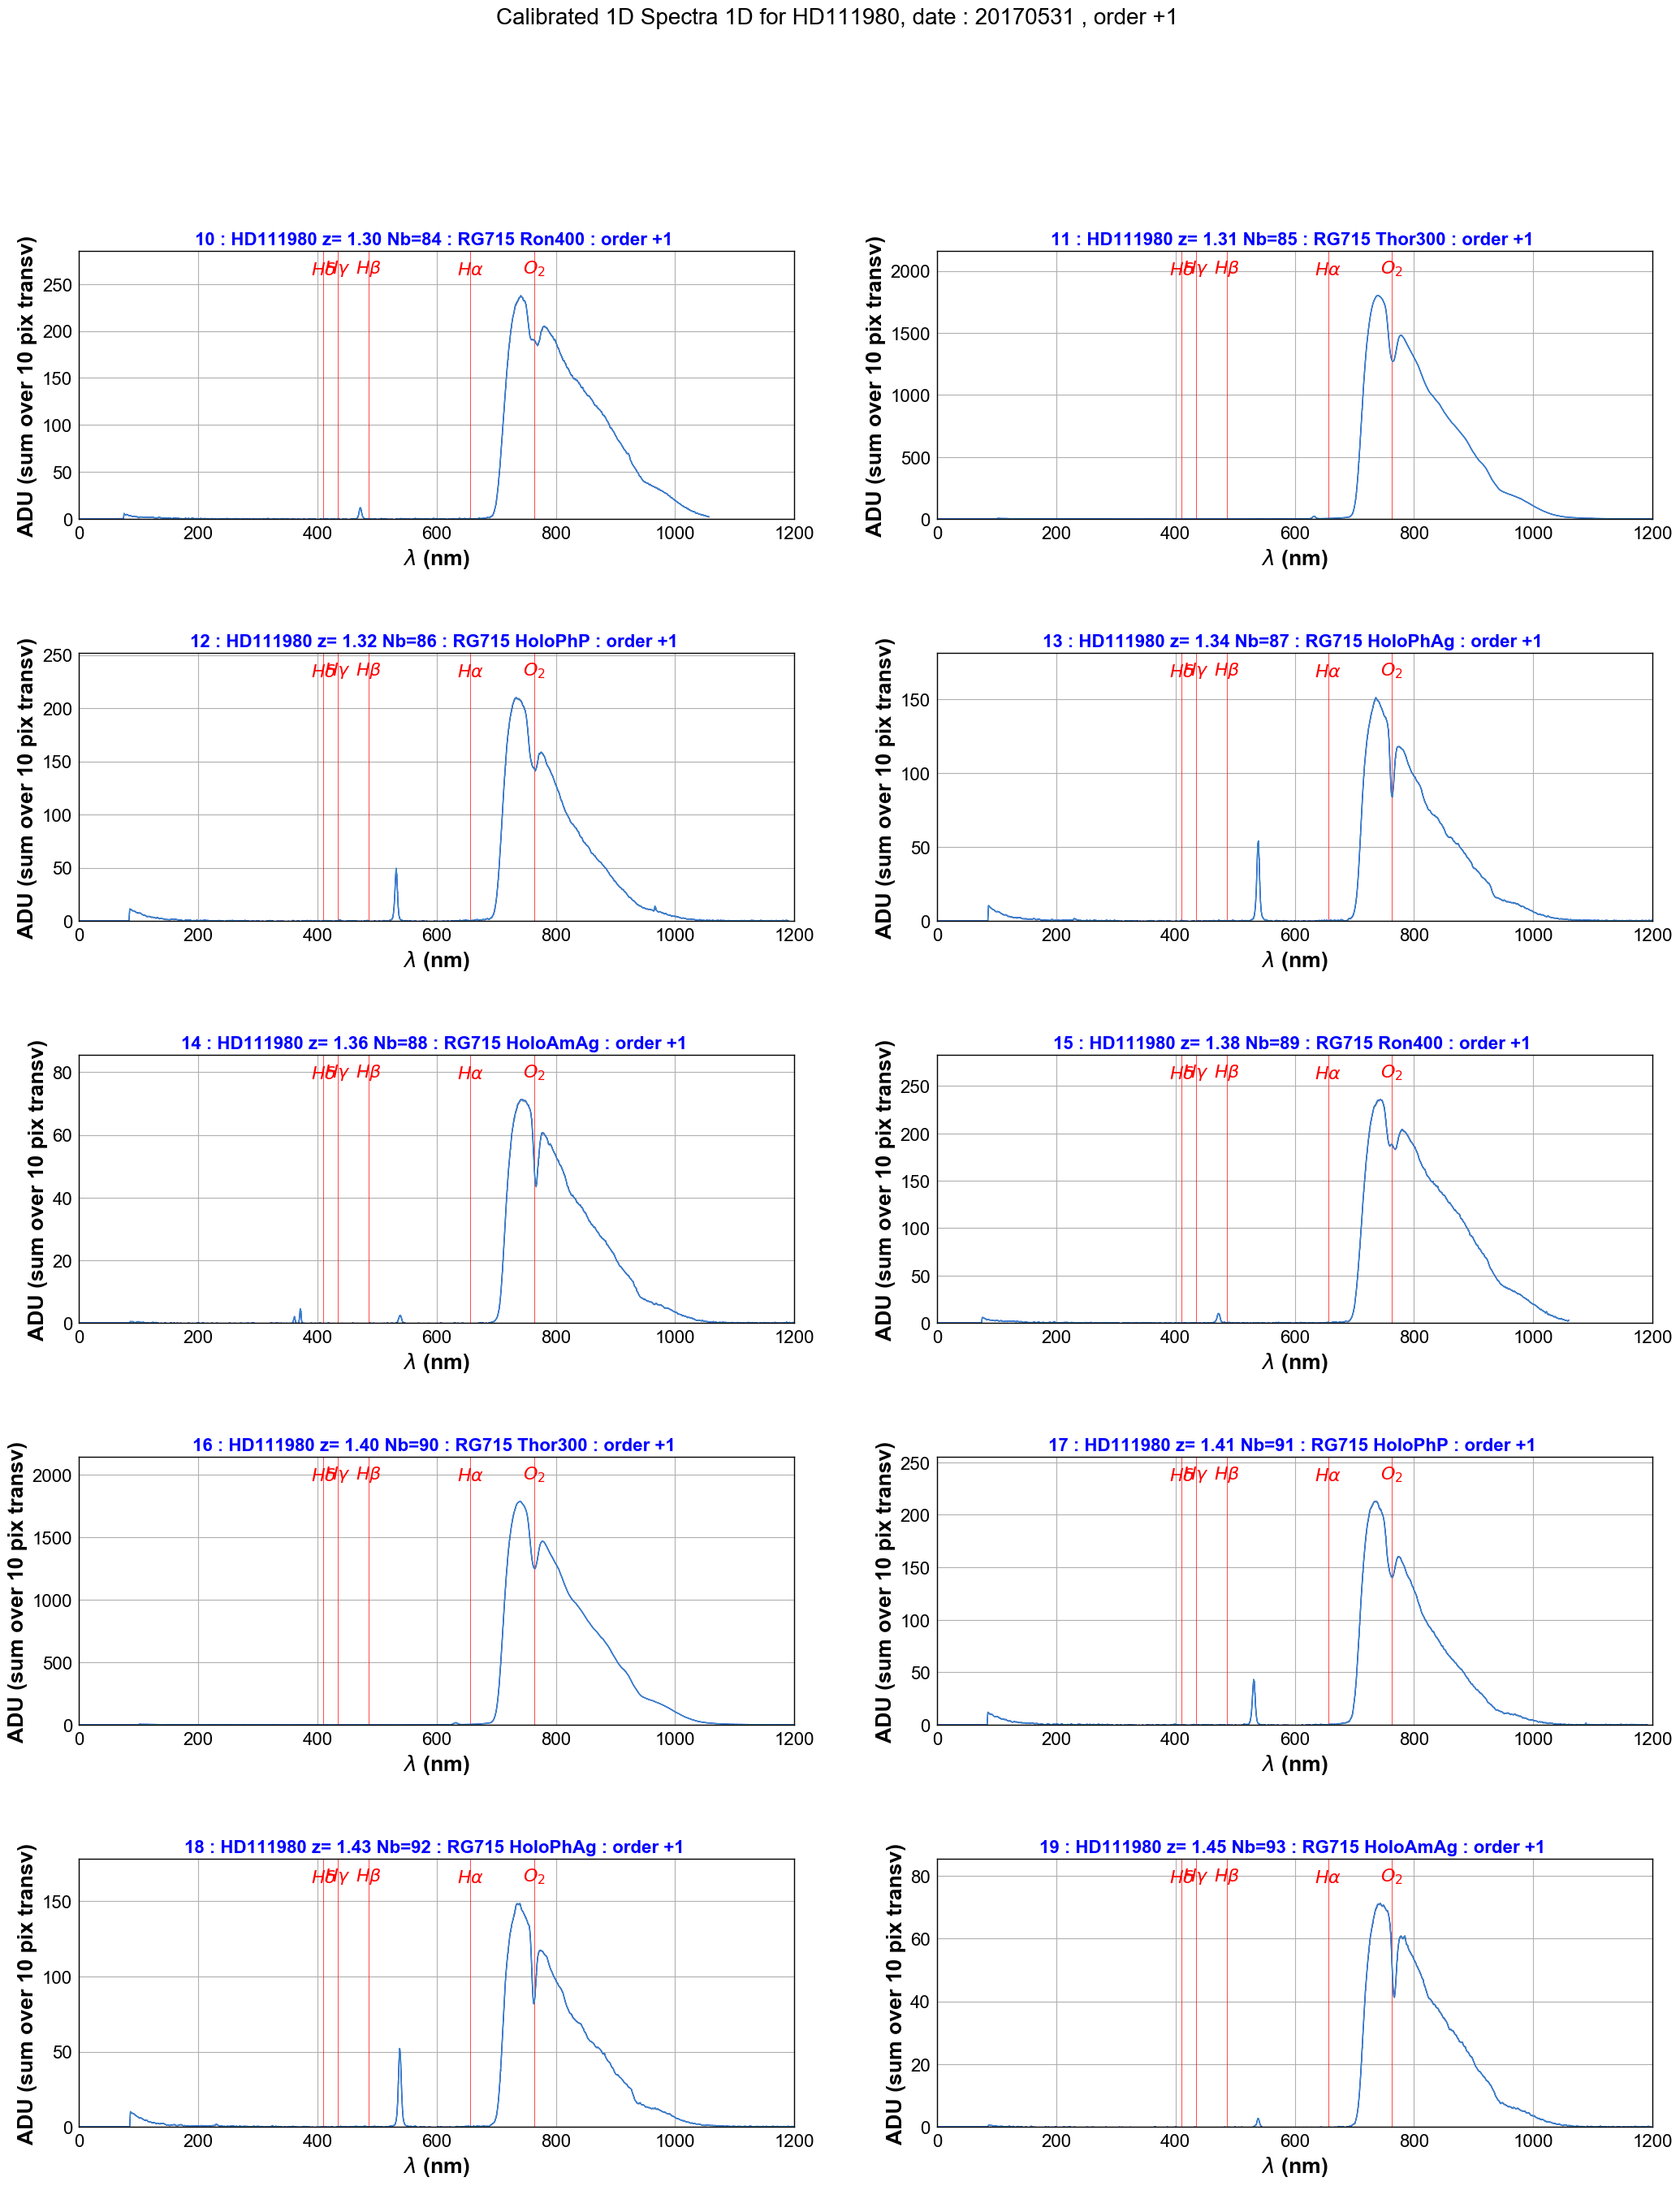

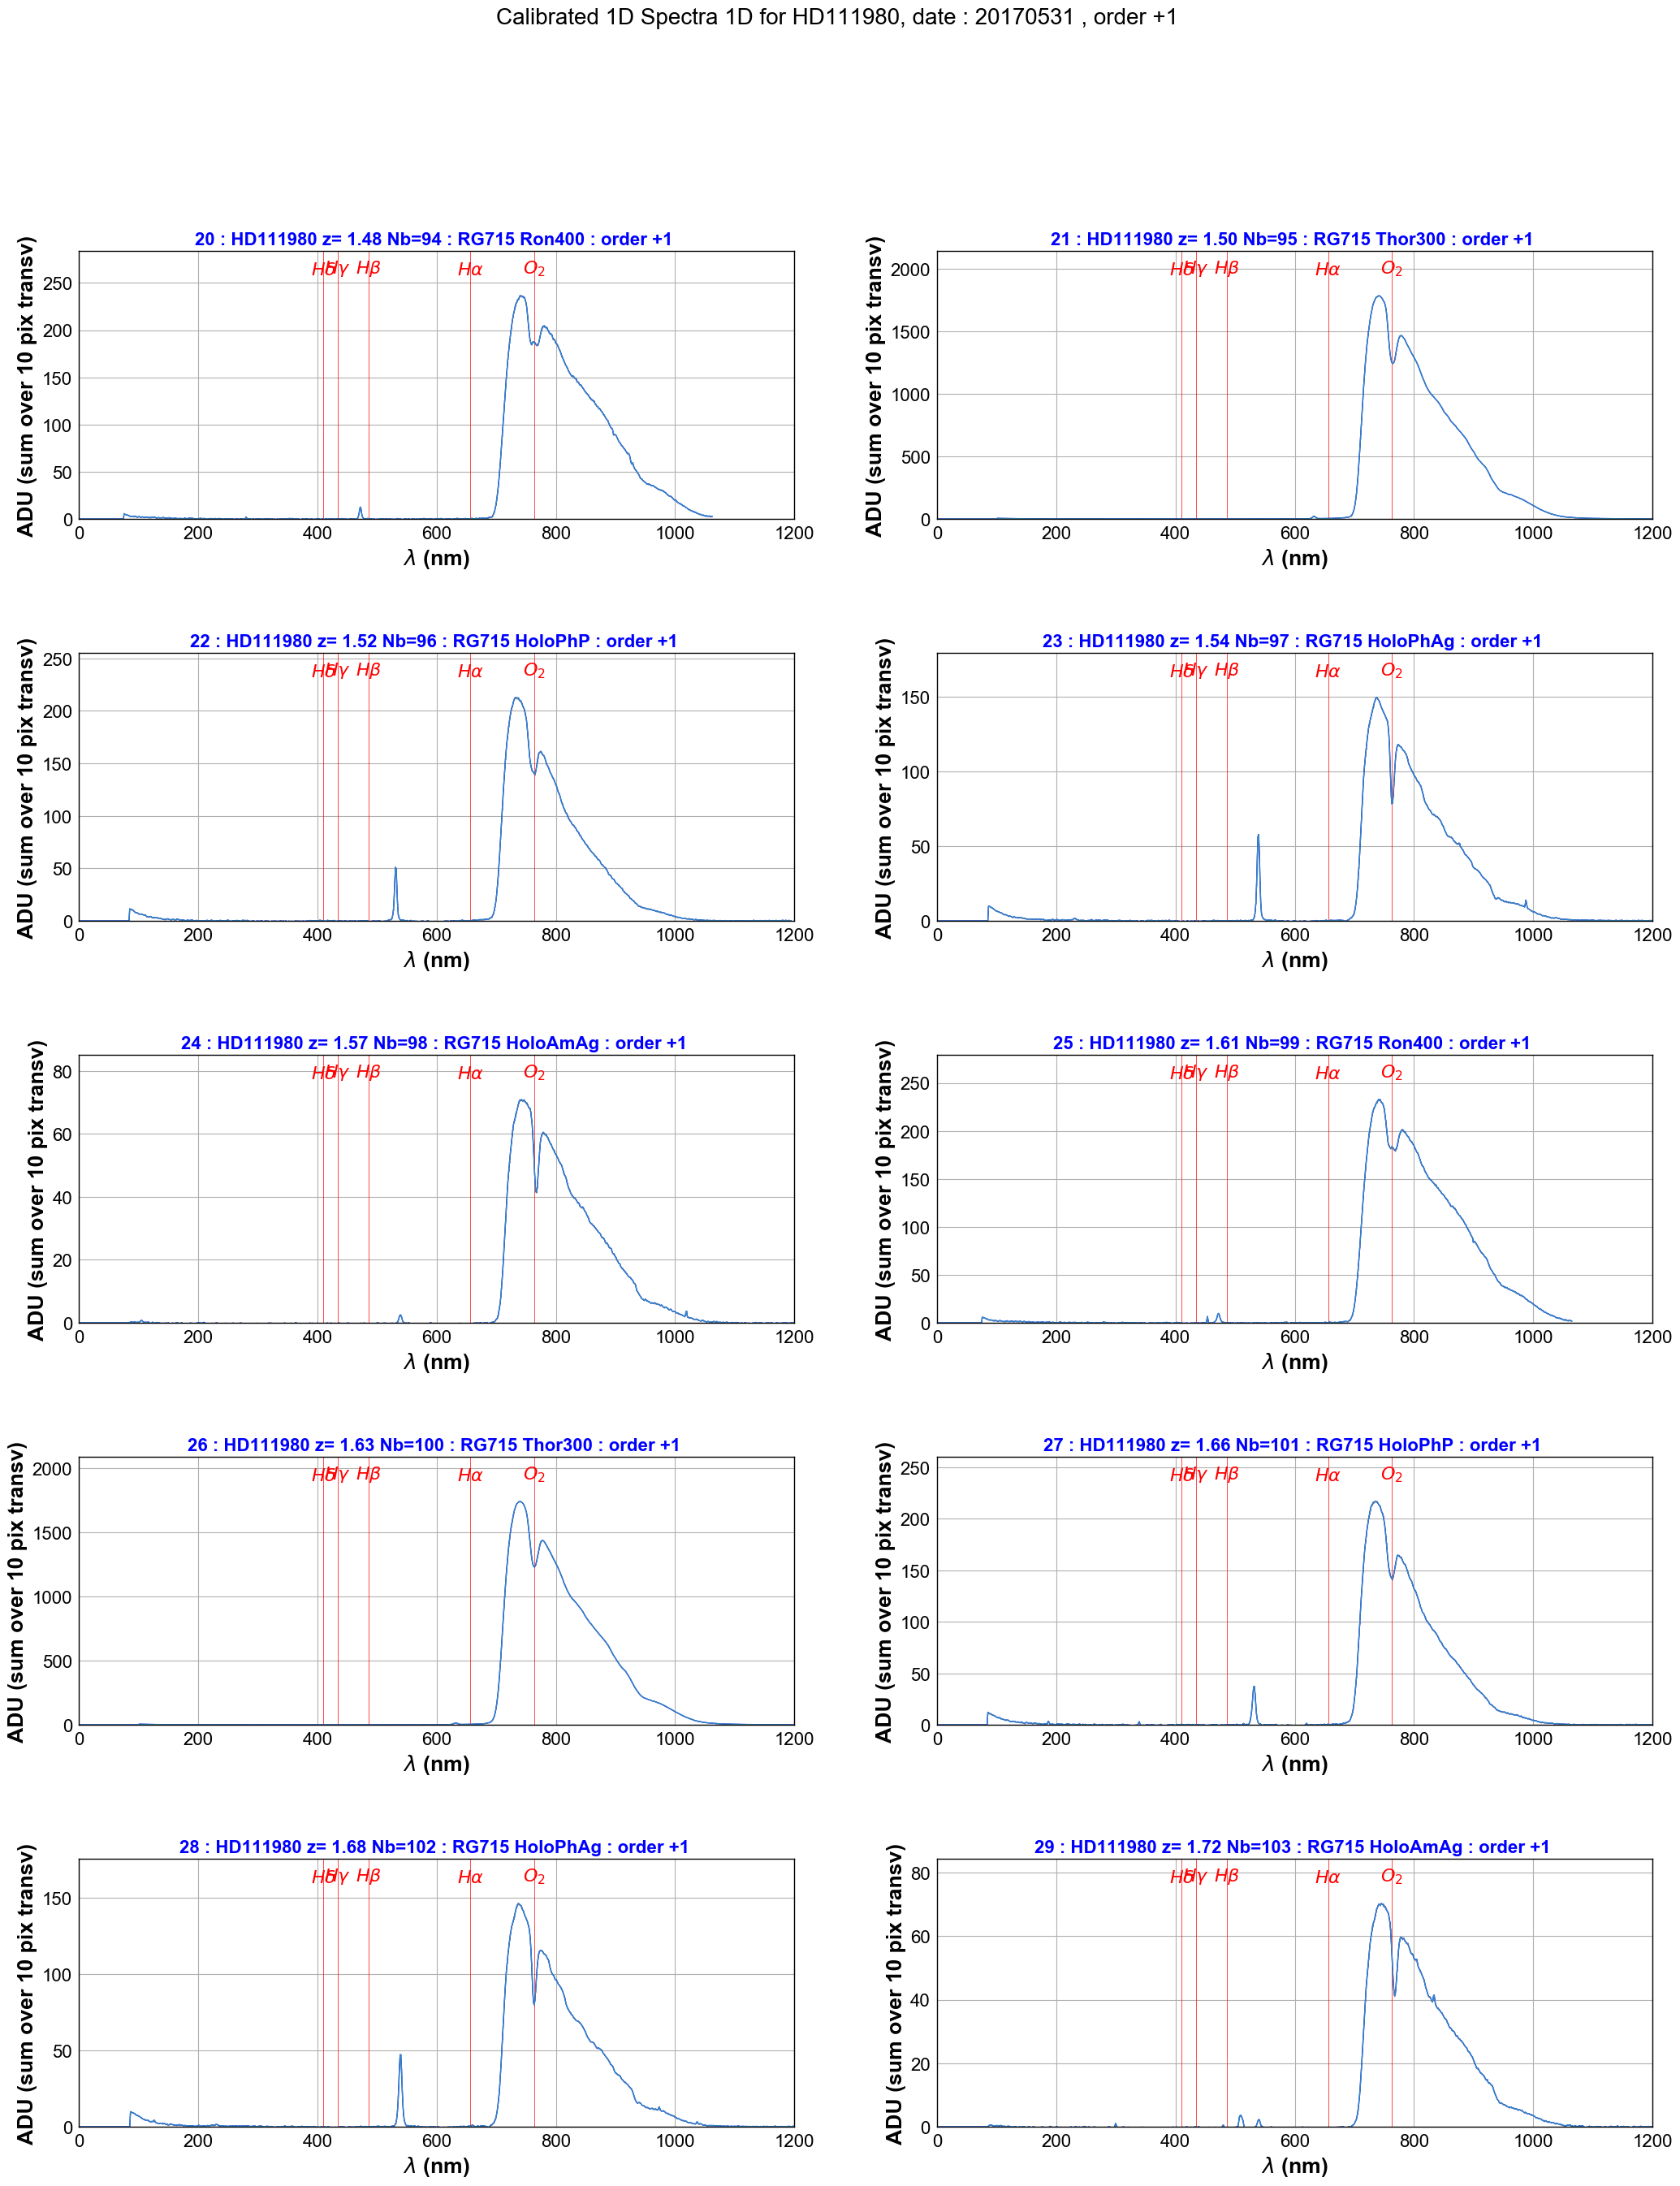

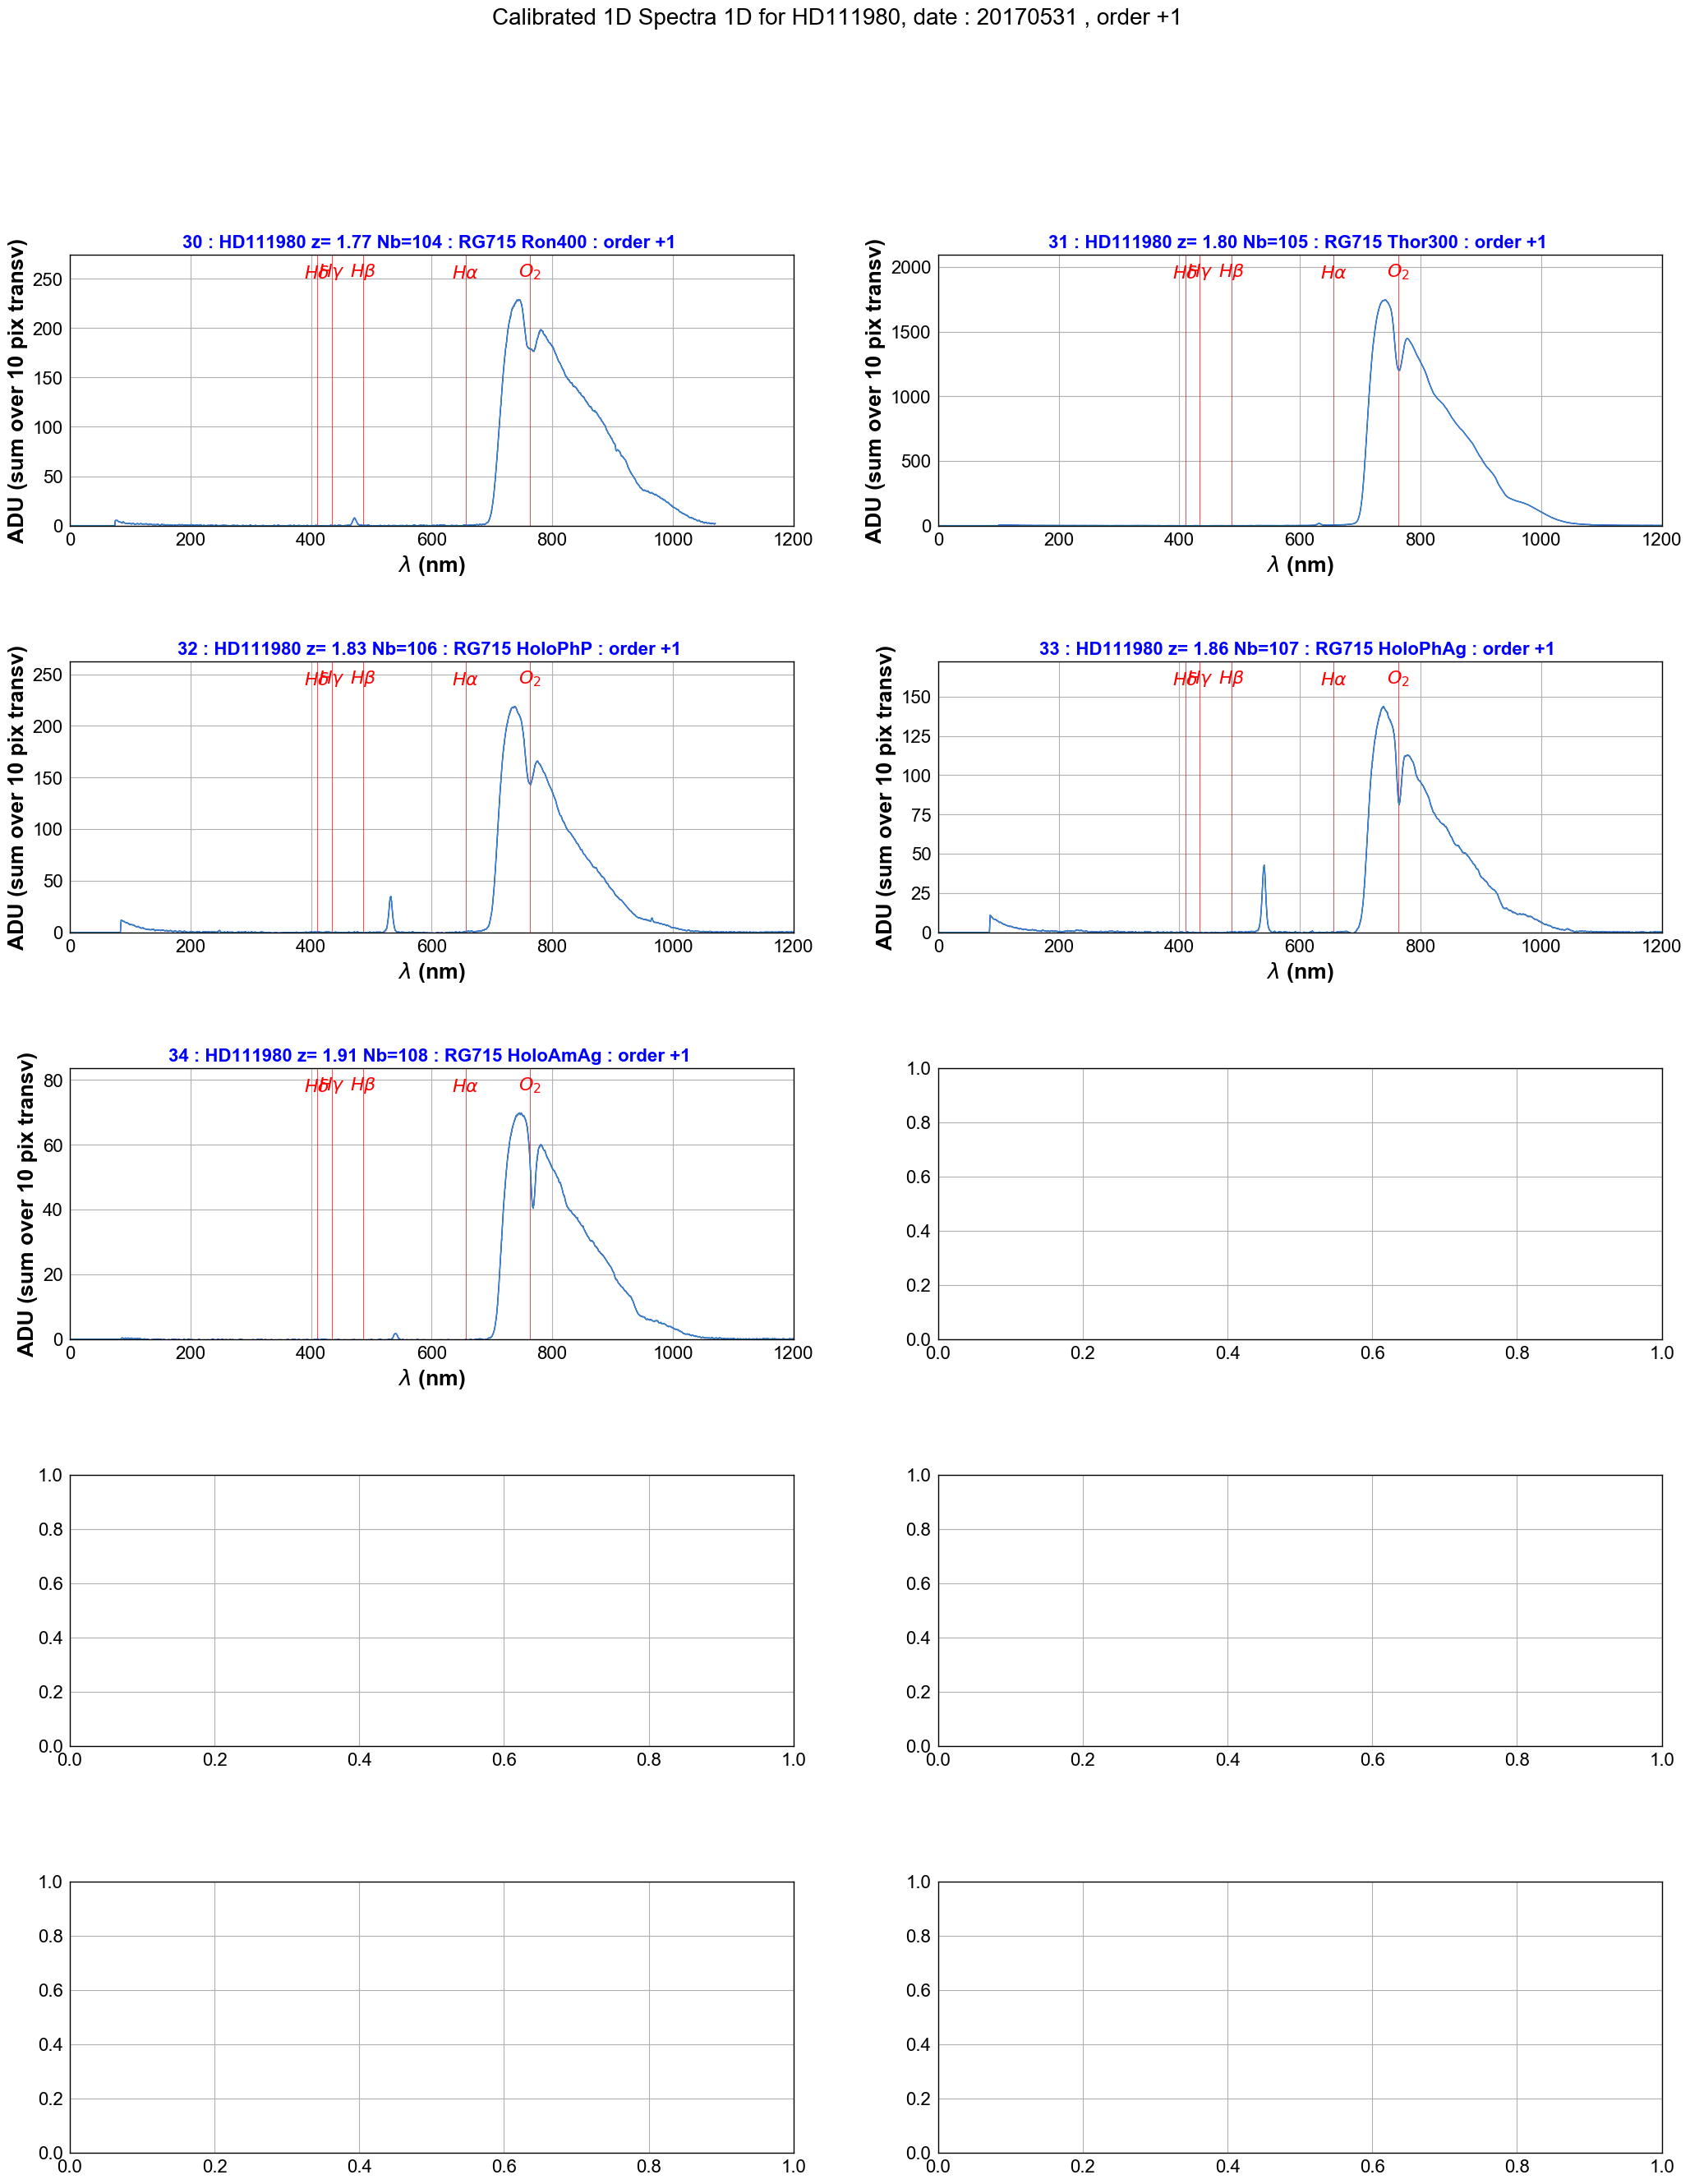

In [37]:
ShowCalibSpectrainPDF(all_rightspectra_data,all_rightspectra_data_stat_err,all_rightspectra_wl,all_titles,object_name,dir_top_images,all_filt,date,'calib1Dspectra_right.pdf','order +1')

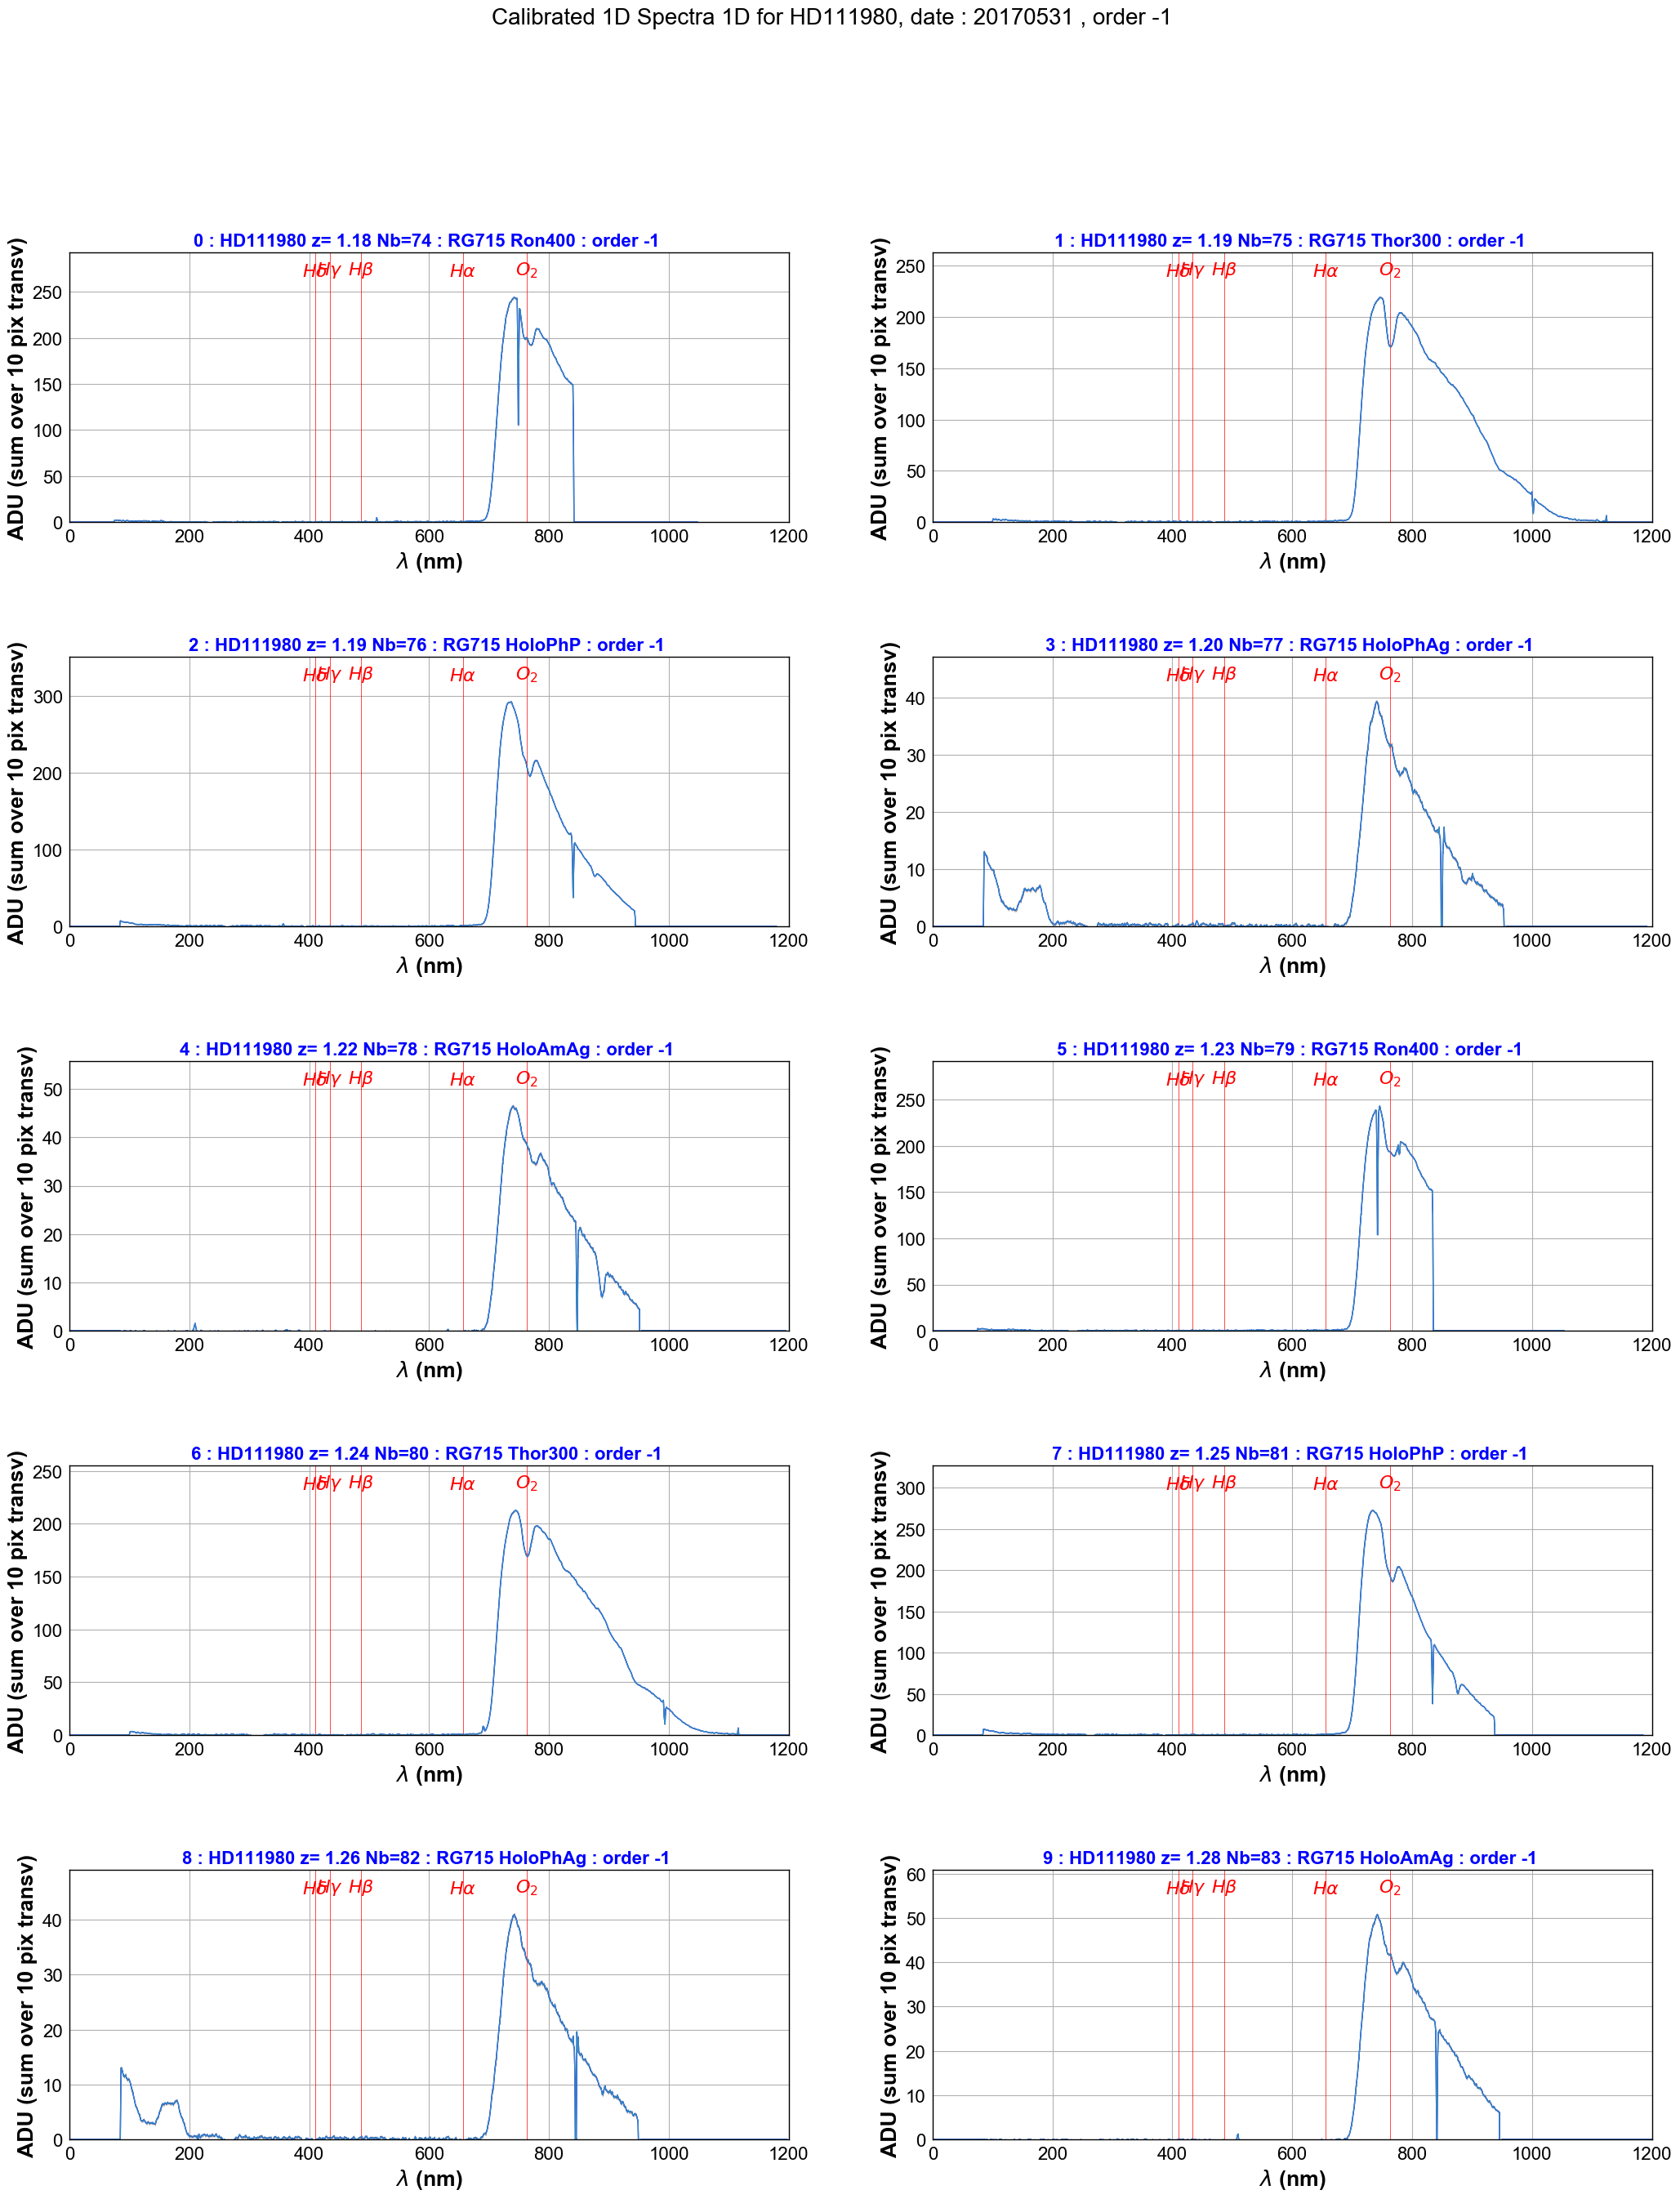

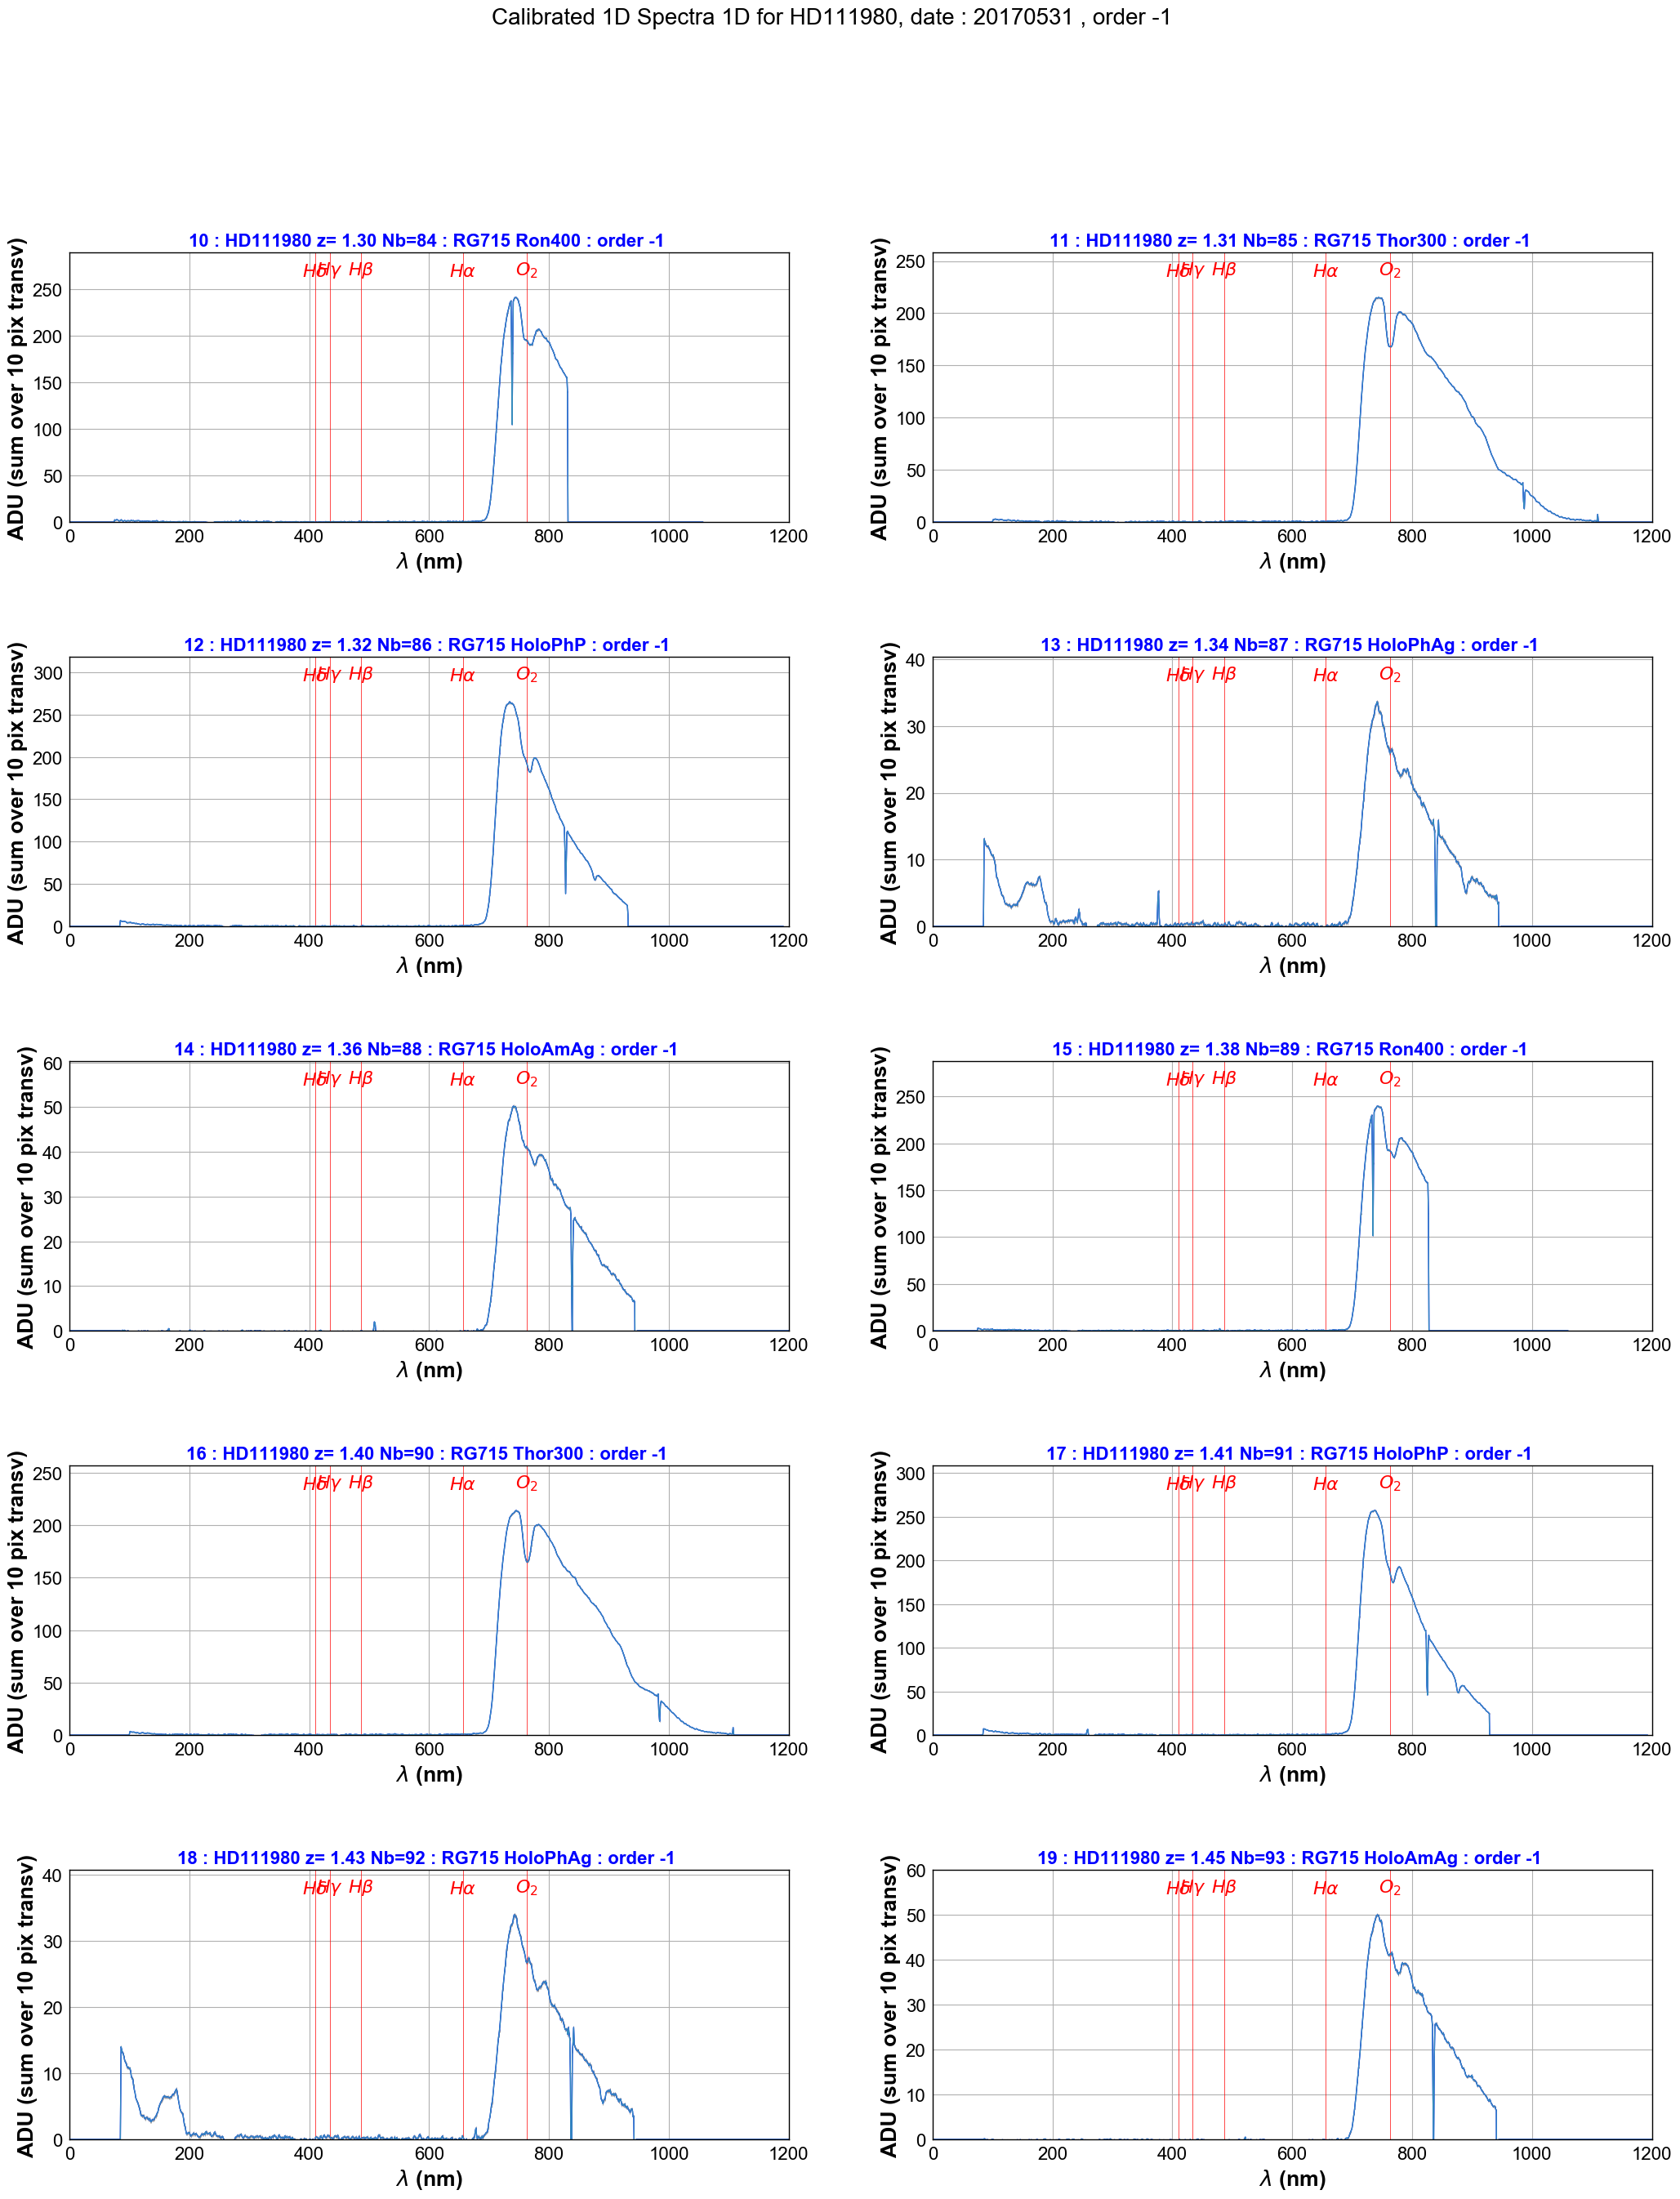

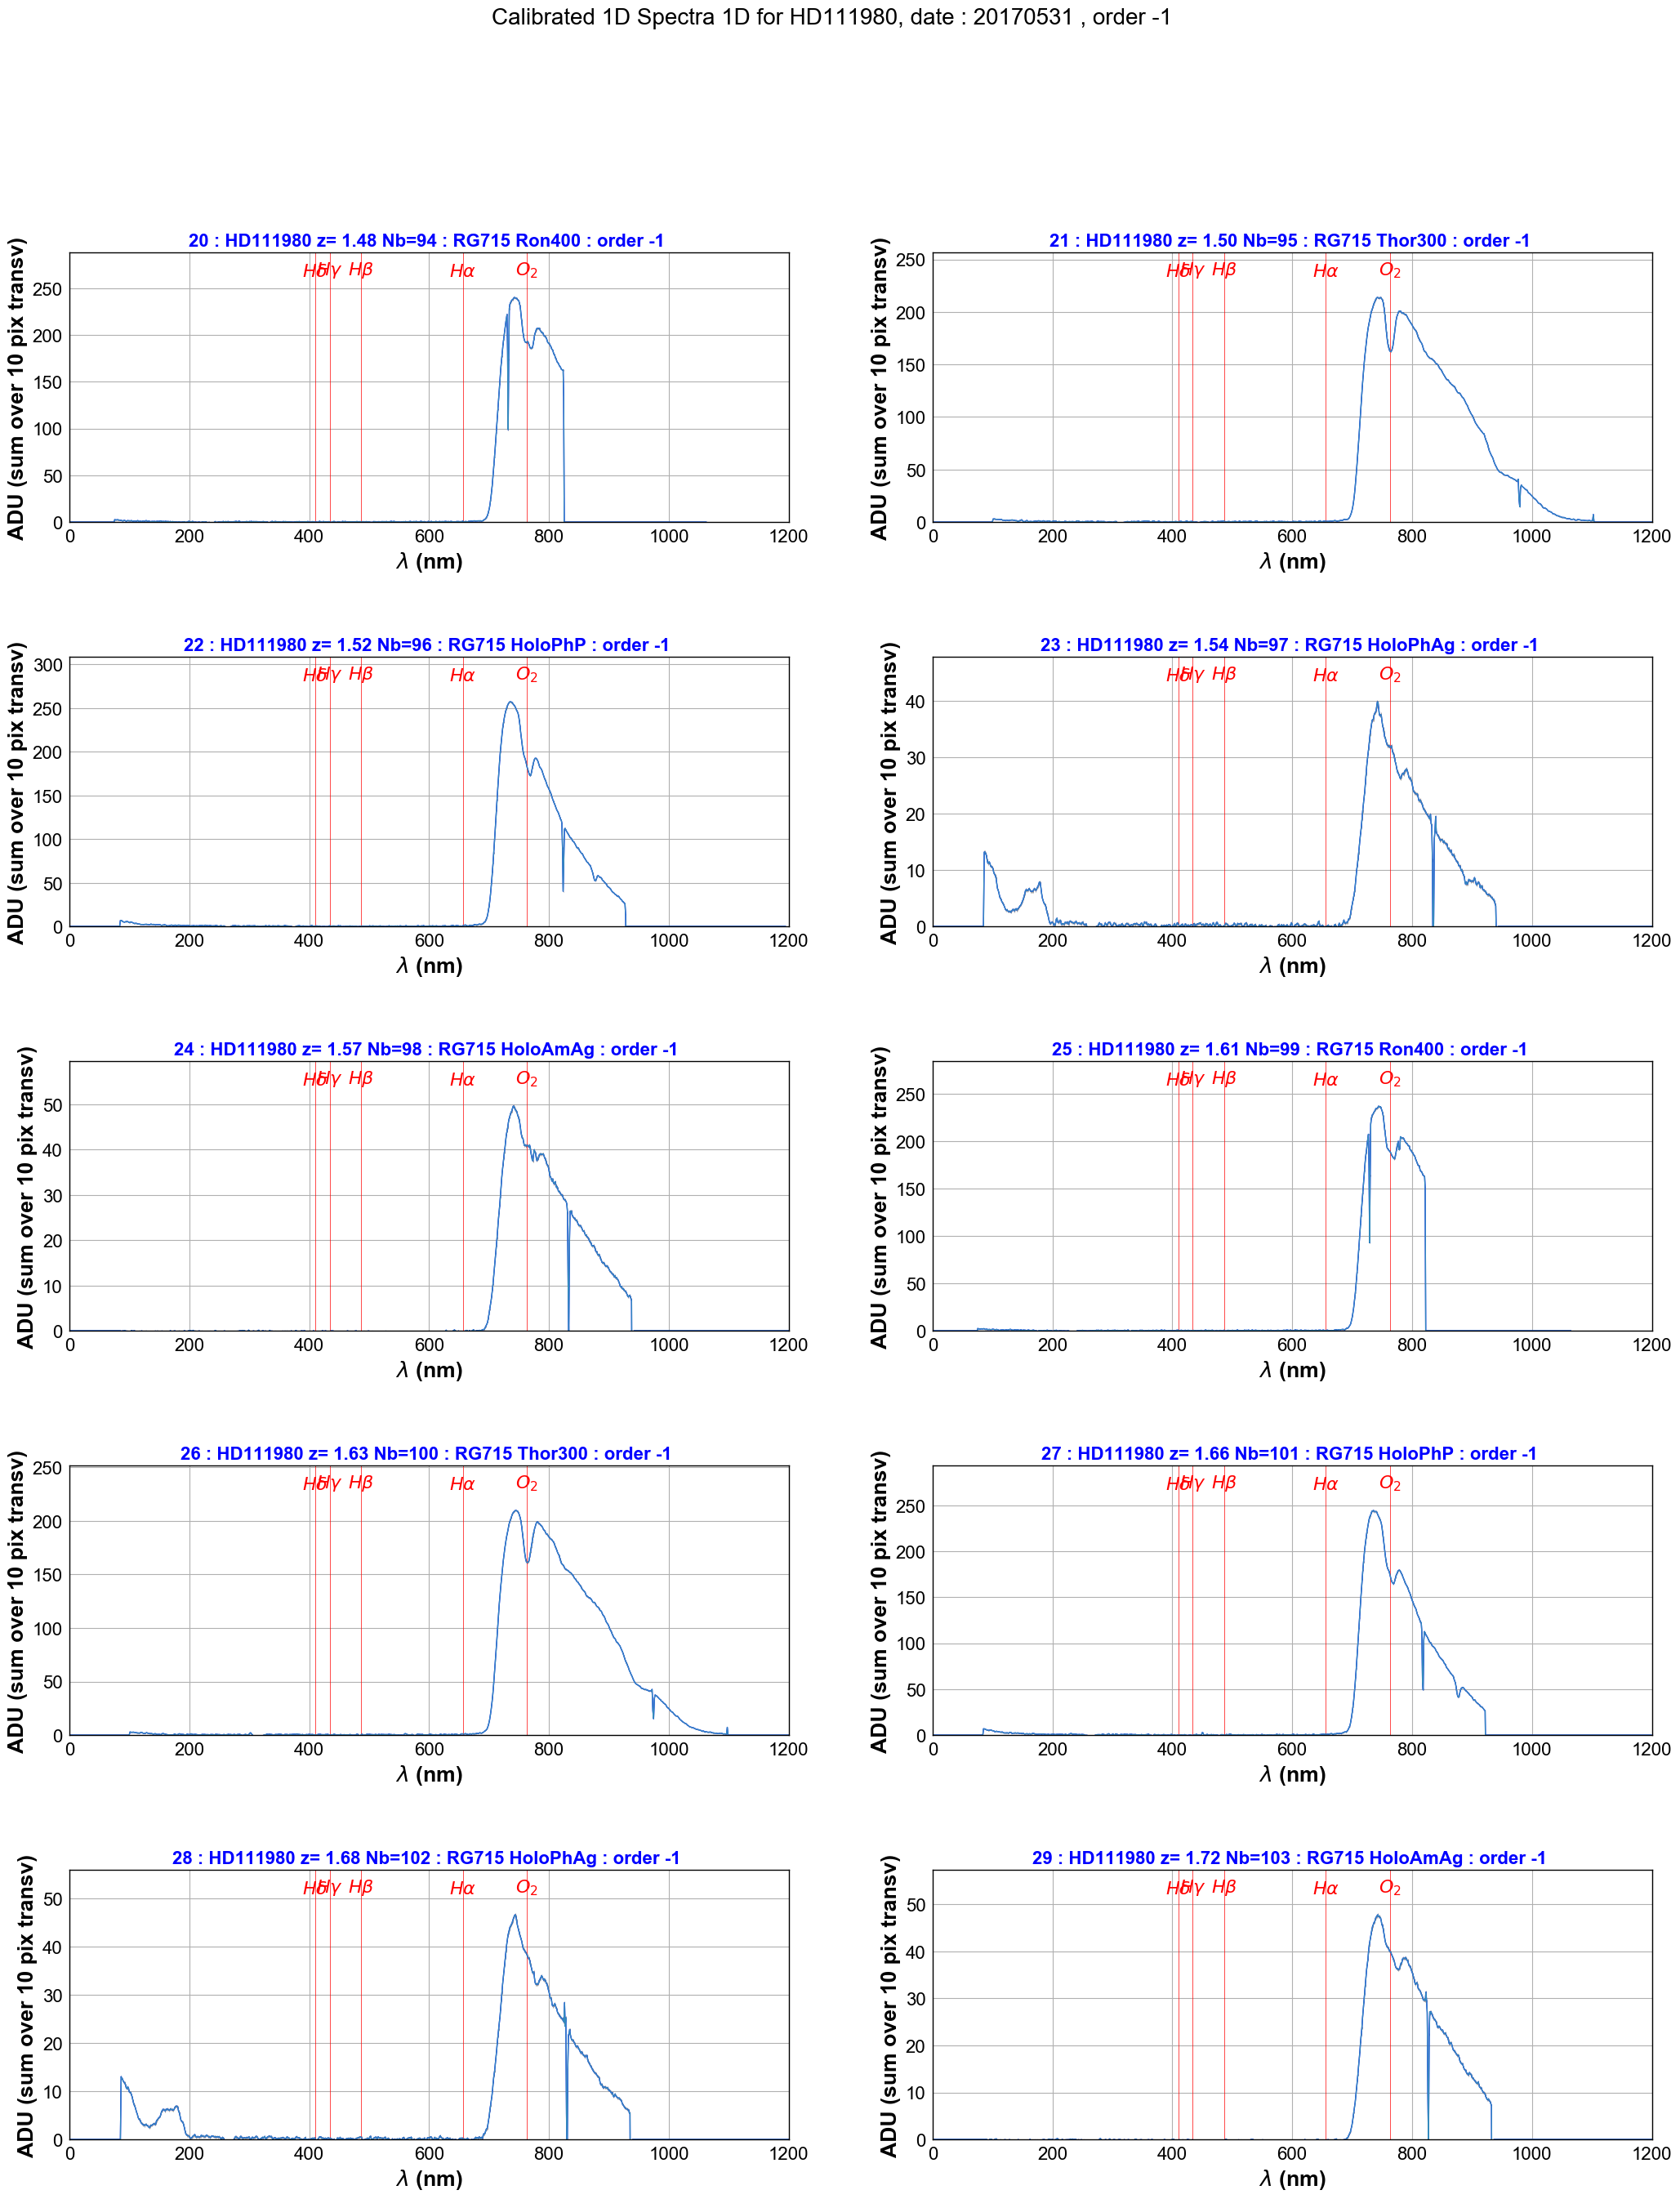

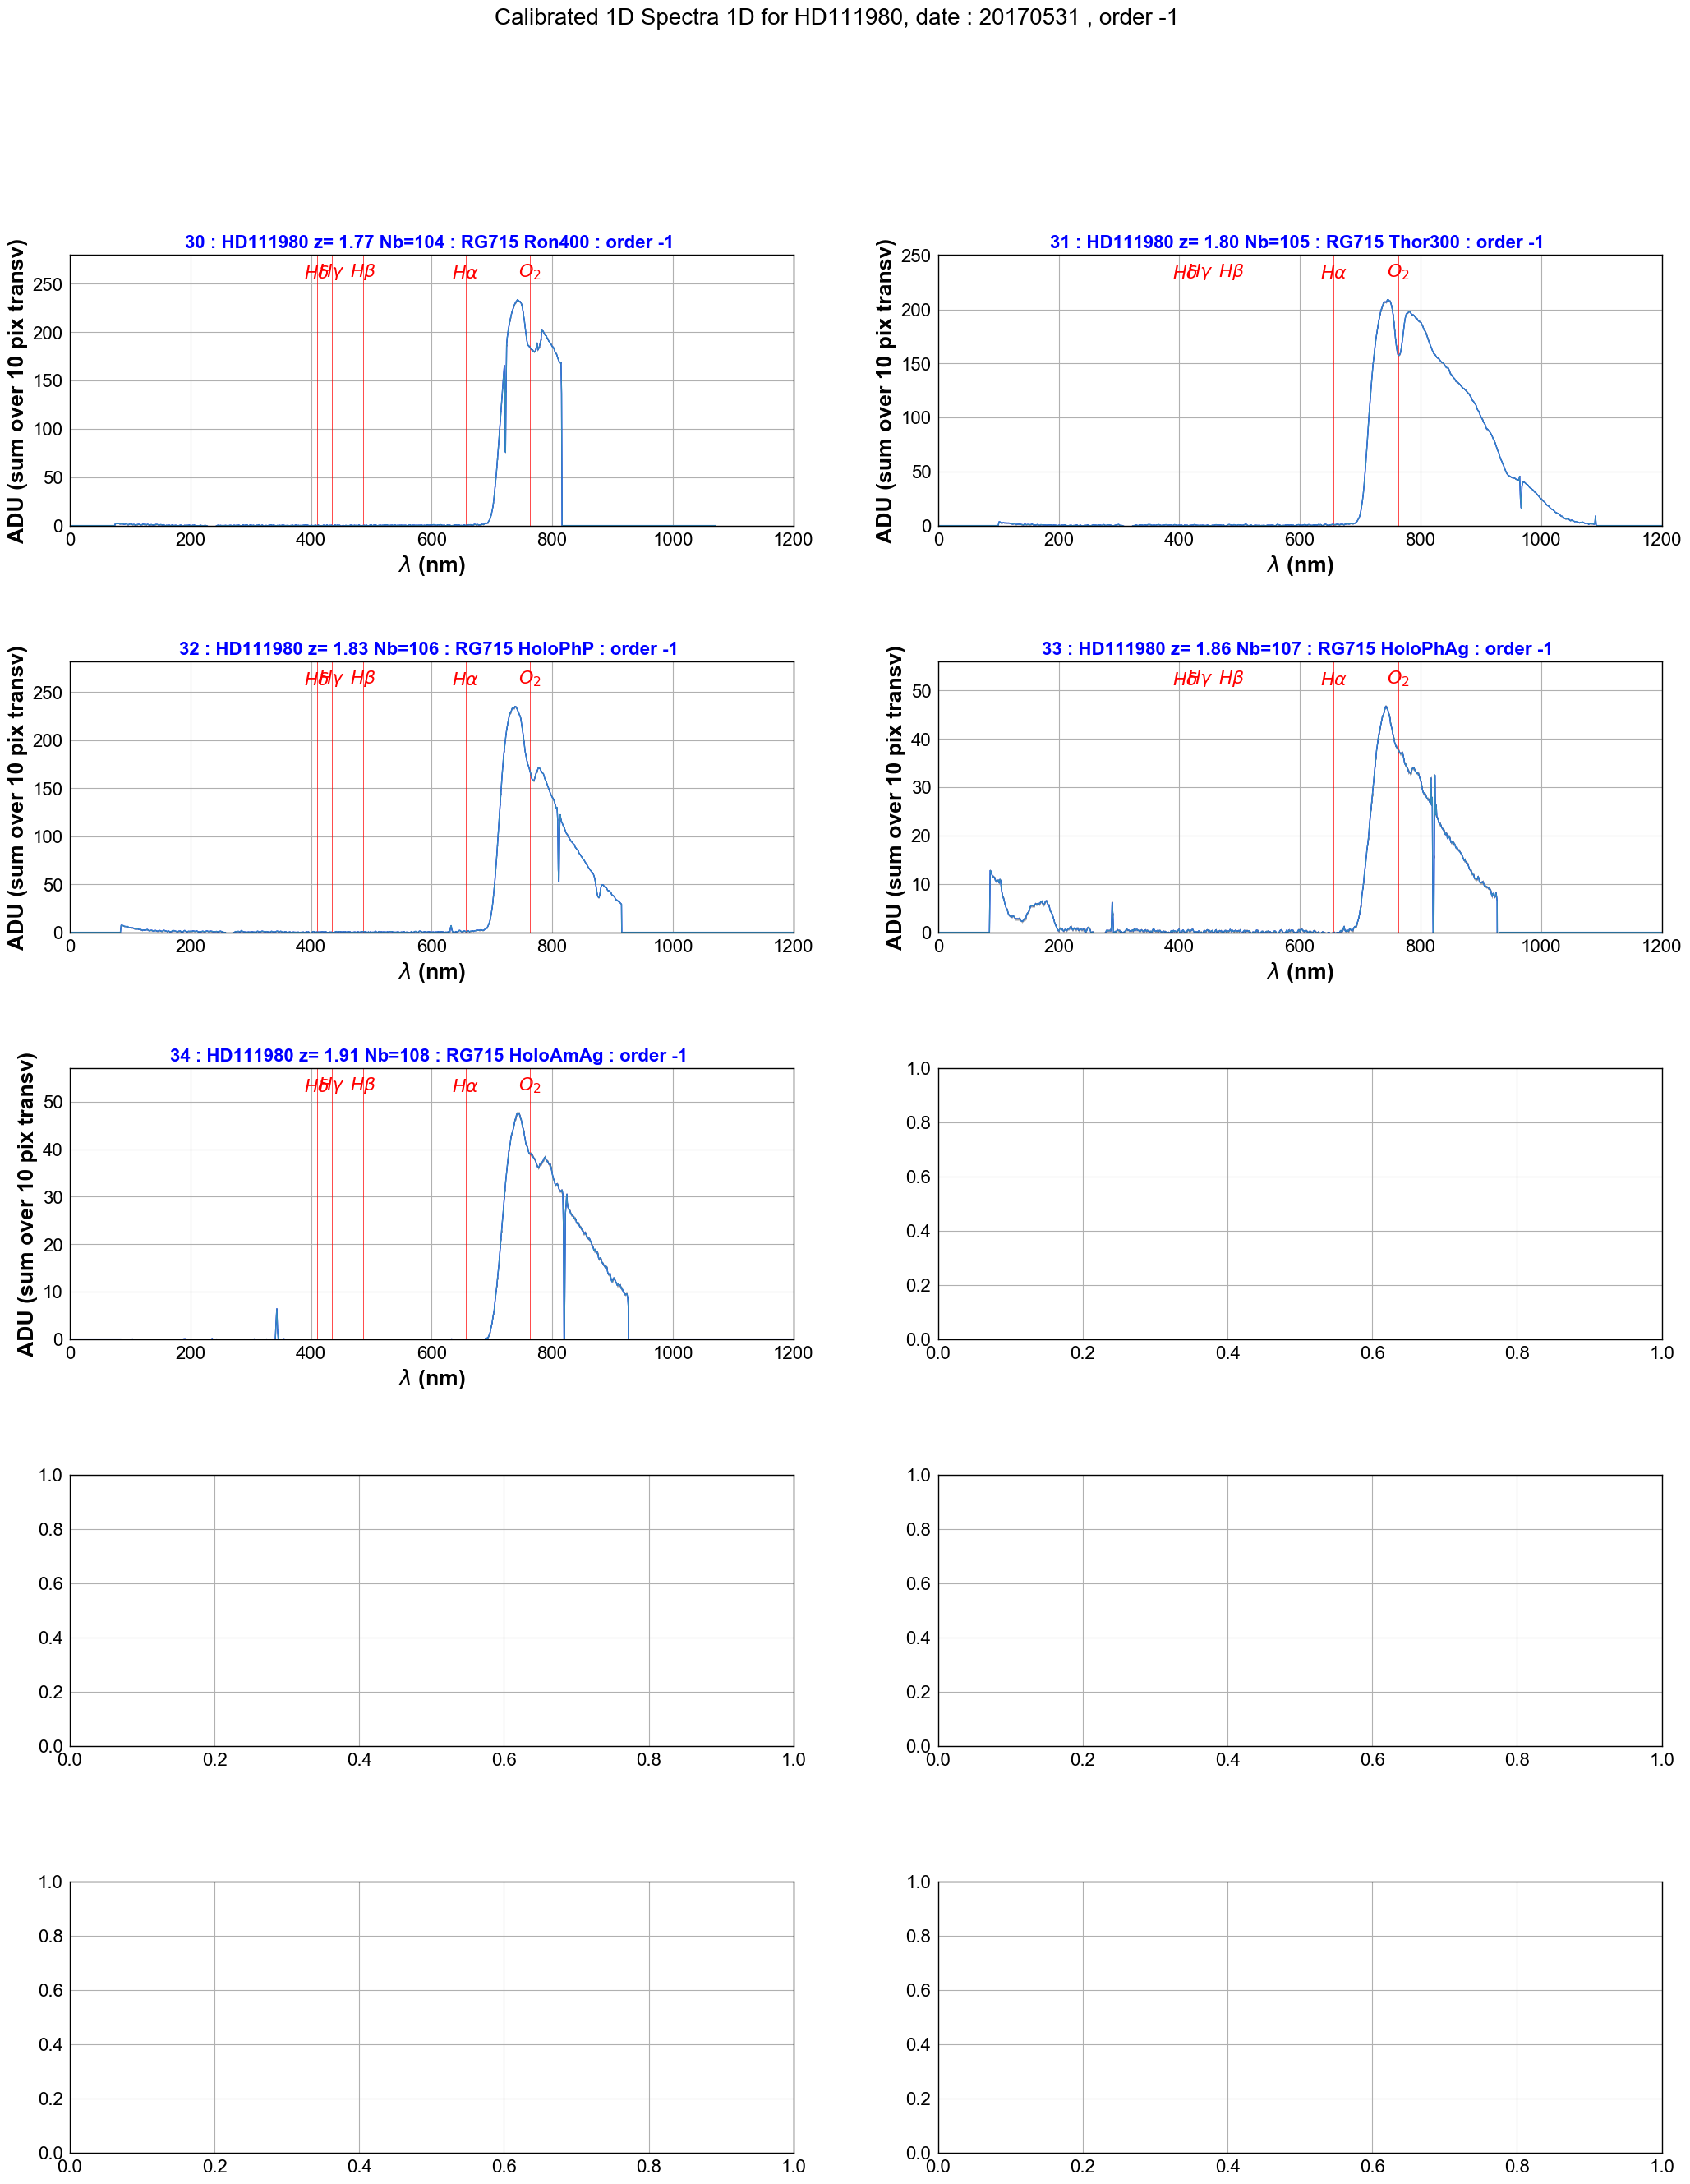

In [38]:
ShowCalibSpectrainPDF(all_leftspectra_data,all_leftspectra_data_stat_err,all_leftspectra_wl,all_titles,object_name,dir_top_images,all_filt,date,'calib1Dspectra_left.pdf','order -1')

# Simulate all atmospheric profiles

- we use typical PWV and Ozone values expected in that region

In [39]:
all_wl_atm= []
all_tr_atm= []
all_bp_atm = []
PWV0=4.0 # mm 
OZ0=300. # Dobson Unit

In [40]:
for index,am in np.ndenumerate(all_airmass):
    idx=index[0]
    # value of all images
    AM=all_airmass[idx]
    PRESS=all_press[idx]
    # Do libradtran simulation
    path,file=ProcessSimulation(AM,PWV0,OZ0,PRESS)   
    fullfilename=os.path.join(path,file)
    atm_data=np.loadtxt(fullfilename)
    wl_atm=atm_data[:,0]
    tr_atm=atm_data[:,1]
    all_wl_atm.append(wl_atm)
    all_tr_atm.append(tr_atm)
    # transform atmosphere in PySynphot filter
    atm_filter_name='CTIO atm {}'.format(idx)
    bp_atm = S.ArrayBandpass(wl_atm*10.,tr_atm, name=atm_filter_name)  # Pysynphot pass band
    all_bp_atm.append(bp_atm) 

--------------------------------------------
 2) airmass =  1.178
 2) pwv =  4.0
 3) oz =  300.0
 4) pressure  =  781.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z11_wv40_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z11_wv40_oz30.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z11_wv40_oz30.INP > simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z11_wv40_oz30.OUT')
--------------------------------------------
 2) airmass =  1.185
 2) pwv =  4.0
 3) oz =  300.0
 4) pressure  =  781.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z11_wv40_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/

--------------------------------------------
 2) airmass =  1.336
 2) pwv =  4.0
 3) oz =  300.0
 4) pressure  =  781.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z13_wv40_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z13_wv40_oz30.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z13_wv40_oz30.INP > simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z13_wv40_oz30.OUT')
--------------------------------------------
 2) airmass =  1.358
 2) pwv =  4.0
 3) oz =  300.0
 4) pressure  =  781.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z13_wv40_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/

--------------------------------------------
 2) airmass =  1.632
 2) pwv =  4.0
 3) oz =  300.0
 4) pressure  =  781.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z16_wv40_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z16_wv40_oz30.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z16_wv40_oz30.INP > simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z16_wv40_oz30.OUT')
--------------------------------------------
 2) airmass =  1.655
 2) pwv =  4.0
 3) oz =  300.0
 4) pressure  =  781.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z16_wv40_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/

# Simulate the full spectrum using the SED

####  Be carefull, filename in header may be badly written 

In [41]:
all_sed_fn= []
for index,obj in np.ndenumerate(all_objects):
     idx=index[0]
     found_sed_flag=False 
     found_sed_fn=None
     for calsed_key in calspec_sed:
        tag_search_sed="{}".format(calsed_key)
        if re.search(tag_search_sed,obj):
            found_sed_fn=calspec_sed[calsed_key]
            found_sed_flag=True
     all_sed_fn.append(found_sed_fn)      

In [42]:
print all_sed_fn

['hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits', 'hd111980_stis_003.fits']


In [43]:
print all_filt1

['RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715', 'RG715']


## Compute the full transmission

- Notice PySymphot is used to multiply SED, transmission that have different wavelength binning.
- PySynphot works in Angstrom wavelength unit

In [44]:
all_obs_spectra = []
all_obs_wl= []
all_obs_fluxes = []
all_obs_sed = []

for index,obj in np.ndenumerate(all_objects):
    idx=index[0]
     # retrieve the SED
    theobjectname=obj
    sed_filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec',all_sed_fn[idx])
    sed = S.FileSpectrum(sed_filename)
    
    # retrieve the filter
    if re.search('RG',all_filt1[idx]):
        bp_ctio=bp_ctio_red
    elif re.search('FB',all_filt1[idx]):
        bp_ctio=bp_ctio_blue
    else:
        bp_ctio=bp_ctio_nof
        
    atm_filter_name='CTIO_atm_{}'.format(idx)
    
    # atmosphere passband
    the_bp_atm= S.ArrayBandpass(all_wl_atm[idx]*10.,all_tr_atm[idx], name=atm_filter_name)  # Pysynphot pass band
    # total passband
    bp_ctio_atm = bp_ctio*the_bp_atm # Multiply atm tansmission by CCD QE efficiciency
    bp_ctio_atm.binning=10.
    
    # now compute the observed spectrum
    obs_ctio = S.Observation(sed,bp_ctio_atm)
    
    #backup
    all_obs_spectra.append(obs_ctio)
    all_obs_wl.append(obs_ctio.wave)
    all_obs_fluxes.append(obs_ctio.flux) 
    all_obs_sed.append(sed)

((((CTIO QE * CTIO Mirror2) * RG175) * CTIO_atm_0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO_atm_1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO_atm_2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO_atm_3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO_atm_4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO_atm_5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO_atm_6)) does not have a de

# View simulated spectra

In [45]:
all_len=[len(all_obs_wl[i]) for i in range(len(all_obs_wl))]

In [46]:
min_len=min(all_len)

In [47]:
def MakeSimNpArray(all_simwavelength,all_simspectra,minlen):
    
    all_simspectra=np.array(all_simspectra)
    simwavelength=np.array(all_simwavelength[0][0:minlen])
    
    NBSPEC=all_simspectra.shape[0]
    NBWL=minlen
    
    print NBSPEC,' , ',NBWL
    dataout=np.zeros((NBSPEC+1,NBWL))
    
    dataout[0,:]=simwavelength
    
    for ispec in np.arange(1,NBSPEC+1):
        dataout[ispec,:]=np.copy(all_simspectra[ispec-1][0:minlen])
    return dataout

In [48]:
spectra_out=MakeSimNpArray(all_obs_wl,all_obs_fluxes,min_len)

35  ,  4840


In [49]:
def AllSimSpectrumProfile(allspectra,all_obs_sed,object_name,dir_top_img):
    """
    CompareSpectrumProfile
    =====================
    
    """
    shortfilename='SimSpec_'+object_name+'.pdf'
    title="Simulated spectra for {}".format(object_name)
    figfilename=os.path.join(dir_top_img,shortfilename)
    pp = PdfPages(figfilename) # create a pdf file
      
    f, axarr = plt.subplots(1,1,figsize=(25,8))  
    f.suptitle(title,size=40)
    
    axarr2 = axarr.twinx()
    axarr2.plot(all_obs_sed[0].wave/10.,all_obs_sed[0].flux*1.2,'b-')
    axarr2.set_ylim(0.,3e-12)
    ytitle="SED flux ({})".format(all_obs_sed[0].fluxunits.name)
    axarr2.set_ylabel(ytitle)
    
    
    # number of spetra
    NBSPEC=allspectra.shape[0]-1
    
    #first row : the wavelengths
    wl=allspectra[0]
        
    maxim_y_to_plot= []

  
    # loop on simulated spectra on all other rows
    for index in np.arange(0,NBSPEC):
                
        axarr.plot(wl/10.,allspectra[index+1],'-',lw=2)
        maxim_y_to_plot.append(allspectra[index+1].max())
    
    axarr.plot(wl/10.,allspectra[0+1],'r-',lw=2)
    
    max_y_to_plot=max(maxim_y_to_plot)
    
    YMIN=0.
    YMAX=max_y_to_plot*1.8
    for line in LINES:
        if line == O2 or line == HALPHA or line == HBETA or line == HGAMMA or line == HDELTA or line ==O2B or line == O2Y or line ==O2Z :
            axarr.plot([line['lambda'],line['lambda']],[YMIN,YMAX],'-',color='red',lw=0.5)
            axarr.text(line['lambda'],0.9*(YMAX-YMIN),line['label'],verticalalignment='bottom', horizontalalignment='center',color='red', fontweight='bold',fontsize=20)
#O2B = {'lambda': 686.719,'atmospheric':True,'label':'$O_2(B)$','pos':[0.007,0.02]} # https://en.wikipedia.org/wiki/Fraunhofer_lines
#O2Y = {'lambda': 898.765,'atmospheric':True,'label':'$O_2(Y)$','pos':[0.007,0.02]} # https://en.wikipedia.org/wiki/Fraunhofer_lines     
    
   
    #axarr.plot([822.696,822.696],[YMIN,YMAX],'-',color='green',lw=0.5)
    #axarr.text(822.696,0.9*(YMAX-YMIN),'$O_2(Z)$',verticalalignment='bottom', horizontalalignment='center',color='green', fontweight='bold',fontsize=20)    
        
    
    axarr.set_ylim(0,max_y_to_plot*2.0)
    #axarr.text(600.,max_y_to_plot*0.9, texte ,verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=30)
    axarr.grid(True)
    axarr.set_xlim(300,1100)
    
    #axarr.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #axarr.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.grid(b=True, which='major', color='grey', linewidth=0.5)
    #axarr.grid(b=True, which='minor', color='grey', linewidth=0.5)
    
    axarr.set_xlabel("wavelength (nm)",fontsize=30)
    axarr.set_ylabel("relative flux (a.u)",fontsize=30)
         
    f.savefig(pp,format='pdf')
    f.show()
    
    pp.close()     
    

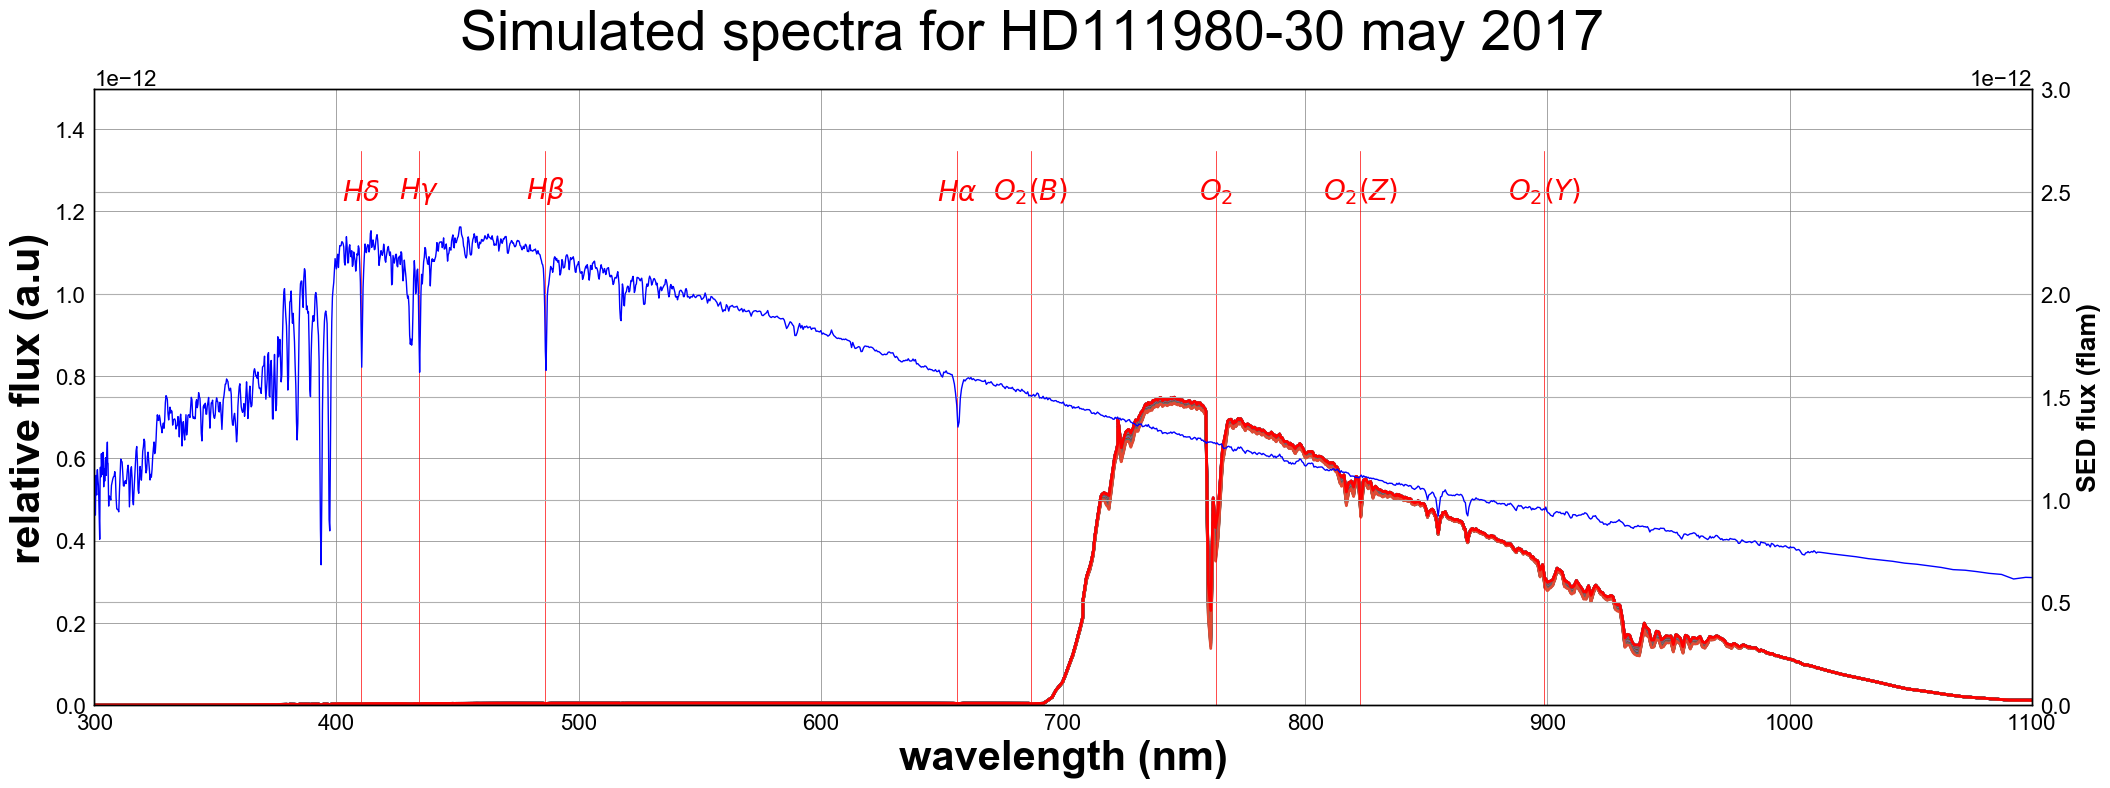

In [50]:
AllSimSpectrumProfile(spectra_out,all_obs_sed,'HD111980-30 may 2017',dir_top_images)

# Remove empty bins for the simulation

- required to avoid empty bins 

In [51]:
all_obs_wl_cut,all_obs_fluxes_cut=RemoveBadWavelengths(all_obs_wl,all_obs_fluxes,WLMIN=3000.,WLMAX=12000.)

In [52]:
all_leftspectra_wl_cut,all_leftspectra_data_cut=RemoveBadWavelengths(all_leftspectra_wl,all_leftspectra_data)
all_rightspectra_wl_cut,all_rightspectra_data_cut=RemoveBadWavelengths(all_rightspectra_wl,all_rightspectra_data)

all_leftspectra_wl_cut,all_totleftspectra_data_cut=RemoveBadWavelengths(all_leftspectra_wl,all_totleftspectra_data)
all_rightspectra_wl_cut,all_totrightspectra_data_cut=RemoveBadWavelengths(all_rightspectra_wl,all_totrightspectra_data)

all_leftspectra_wl_cut,all_leftspectra_data_stat_err_cut=RemoveBadWavelengths(all_leftspectra_wl,all_leftspectra_data_stat_err)
all_rightspectra_wl_cut,all_rightspectra_data_stat_err_cut=RemoveBadWavelengths(all_rightspectra_wl,all_rightspectra_data_stat_err)

# Save calibrated and simulated spectra

In [53]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^calibSpectra_(.*)',short_infilename)
    short_outfilename='calibandSimSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [54]:
newfullfilenames[0:5]

['./simandcalibspec/calibandSimSpectra_20170531_074.fits',
 './simandcalibspec/calibandSimSpectra_20170531_075.fits',
 './simandcalibspec/calibandSimSpectra_20170531_076.fits',
 './simandcalibspec/calibandSimSpectra_20170531_077.fits',
 './simandcalibspec/calibandSimSpectra_20170531_078.fits']

In [55]:
#
#  New fashion to save a binary table outside the primary header
#
for idx,file in np.ndenumerate(newfullfilenames):
    primhdu = fits.PrimaryHDU(header=all_headers[idx[0]])   # make an primary HDU without data
    
    col1=fits.Column(name='CalibLeftSpecWL',format='E',array=all_leftspectra_wl_cut[idx[0]])
    col2=fits.Column(name='CalibLeftSpec',format='E',array=all_leftspectra_data_cut[idx[0]])
    col3=fits.Column(name='CalibTotLeftSpec',format='E',array=all_totleftspectra_data_cut[idx[0]])
    col4=fits.Column(name='CalibRightSpecWL',format='E',array=all_rightspectra_wl_cut[idx[0]])
    col5=fits.Column(name='CalibRightSpec',format='E',array=all_rightspectra_data_cut[idx[0]])
    col6=fits.Column(name='CalibTotRightSpec',format='E',array=all_totrightspectra_data_cut[idx[0]])
    col7=fits.Column(name='CalibStatErrorLeftSpec',format='E',array=all_leftspectra_data_stat_err_cut[idx[0]])
    col8=fits.Column(name='CalibStatErrorRightSpec',format='E',array=all_rightspectra_data_stat_err_cut[idx[0]])
    col9=fits.Column(name='SimSpecWL',format='E',array=all_obs_wl_cut[idx[0]]/10.) ## Convert wl from Angstr into nm
    col10=fits.Column(name='SimSpec',format='E',array=all_obs_fluxes_cut[idx[0]])
    cols=fits.ColDefs([col1,col2,col3,col4,col5,col6,col7,col8,col9,col10])
   
    
    tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU
    thdulist = fits.HDUList([primhdu, tbhdu])
    
    thdulist.writeto(file,overwrite=True)

In [56]:
ls -l ./simandcalibspec/

total 9520
-rw-r--r--  1 dagoret  staff  135360 Oct 21 20:26 calibandSimSpectra_20170531_074.fits
-rw-r--r--  1 dagoret  staff  135360 Oct 21 20:26 calibandSimSpectra_20170531_075.fits
-rw-r--r--  1 dagoret  staff  135360 Oct 21 20:26 calibandSimSpectra_20170531_076.fits
-rw-r--r--  1 dagoret  staff  135360 Oct 21 20:26 calibandSimSpectra_20170531_077.fits
-rw-r--r--  1 dagoret  staff  135360 Oct 21 20:26 calibandSimSpectra_20170531_078.fits
-rw-r--r--  1 dagoret  staff  135360 Oct 21 20:26 calibandSimSpectra_20170531_079.fits
-rw-r--r--  1 dagoret  staff  135360 Oct 21 20:26 calibandSimSpectra_20170531_080.fits
-rw-r--r--  1 dagoret  staff  135360 Oct 21 20:26 calibandSimSpectra_20170531_081.fits
-rw-r--r--  1 dagoret  staff  135360 Oct 21 20:26 calibandSimSpectra_20170531_082.fits
-rw-r--r--  1 dagoret  staff  135360 Oct 21 20:26 calibandSimSpectra_20170531_083.fits
-rw-r--r--  1 dagoret  staff  135360 Oct 21 20:26 calibandSimSpectra_20170531_084.fits
-rw-r--r--  1 dagoret  staff  13